In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the matrices
matrix1 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation/alpaca_cleaned_no_safety/attribution/atten_attr.pt')
matrix2 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation/alpaca_cleaned_no_safety/attribution/mlp_attr.pt')
matrix3 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation_set_difference/align/attribution/atten_attr.pt')
matrix4 = torch.load('/home/jli265/workspace/alignment-attribution-code/out2/llama2-7b-chat-hf/structured/fluctuation_set_difference/align/attribution/mlp_attr.pt')

def calculate_role_transfer(matrix1, matrix2, matrix3, matrix4):
    # Flatten the matrices for easy comparison
    mat1_flat = matrix1.flatten()
    mat2_flat = matrix2.flatten()
    mat3_flat = matrix3.flatten()
    mat4_flat = matrix4.flatten()

    # Calculate the total number of elements
    total_elements_att = mat1_flat.numel()
    total_elements_mlp = mat2_flat.numel()

    # Initialize role transfer arrays
    att_transfer = torch.zeros((2, 4), dtype=torch.float32)  # 2 original roles (0, 1) and 4 new roles (0, 1, 2, 3)
    mlp_transfer = torch.zeros((2, 4), dtype=torch.float32)

    # Calculate the role transfer percentage for attention module
    for i in range(2):
        for j in range(4):
            att_transfer[i, j] = torch.sum((mat1_flat == i) & (mat3_flat == j)).float() / total_elements_att

    # Calculate the role transfer percentage for MLP module
    for i in range(2):
        for j in range(4):
            mlp_transfer[i, j] = torch.sum((mat2_flat == i) & (mat4_flat == j)).float() / total_elements_mlp

    # Calculate block level transfer
    block_transfer_att = torch.zeros((matrix1.shape[0], 2, 4), dtype=torch.float32)
    for b in range(matrix1.shape[0]):
        block_flat1 = matrix1[b].flatten()
        block_flat3 = matrix3[b].flatten()
        for i in range(2):
            for j in range(4):
                block_transfer_att[b, i, j] = torch.sum((block_flat1 == i) & (block_flat3 == j)).float() / block_flat1.numel()

    block_transfer_mlp = torch.zeros((matrix2.shape[0], 2, 4), dtype=torch.float32)
    for b in range(matrix2.shape[0]):
        block_flat2 = matrix2[b].flatten()
        block_flat4 = matrix4[b].flatten()
        for i in range(2):
            for j in range(4):
                block_transfer_mlp[b, i, j] = torch.sum((block_flat2 == i) & (block_flat4 == j)).float() / block_flat2.numel()

    # Calculate global level transfer rates
    global_transfer = torch.zeros((2, 4), dtype=torch.float32)
    for i in range(2):
        for j in range(4):
            global_transfer[i, j] = (torch.sum((mat1_flat == i) & (mat3_flat == j)) + torch.sum((mat2_flat == i) & (mat4_flat == j))).float() / (total_elements_att + total_elements_mlp)

    return att_transfer, mlp_transfer, block_transfer_att, block_transfer_mlp, global_transfer

att_transfer, mlp_transfer, block_transfer_att, block_transfer_mlp, global_transfer = calculate_role_transfer(matrix1, matrix2, matrix3, matrix4)

print("Attention Module Role Transfer Percentages (global):\n", att_transfer.numpy())
print("MLP Module Role Transfer Percentages (global):\n", mlp_transfer.numpy())
print("Attention Module Role Transfer Percentages (block level):\n", block_transfer_att.numpy())
print("MLP Module Role Transfer Percentages (block level):\n", block_transfer_mlp.numpy())
print("Global Role Transfer Rates:\n", global_transfer.numpy())



Attention Module Role Transfer Percentages (global):
 [[0.         0.         0.         0.        ]
 [0.         0.00390625 0.03320312 0.9628906 ]]
MLP Module Role Transfer Percentages (global):
 [[0.12094045 0.0015642  0.         0.02691792]
 [0.02811024 0.01144622 0.13301405 0.6780069 ]]
Attention Module Role Transfer Percentages (block level):
 [[[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.      1.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.      0.

In [2]:
def plot_global_transfer(global_transfer):
    fig, ax = plt.subplots(figsize=(10, 6))
    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']
    im = ax.imshow(global_transfer.numpy(), cmap="Blues")

    # Show all ticks and label them
    ax.set_xticks(np.arange(len(new_roles)))
    ax.set_yticks(np.arange(len(roles)))

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if global_transfer[i, j] > 0.5 else "black"
            text = ax.text(j, i, f'{global_transfer[i, j]:.2%}',
                           ha="center", va="center", color=color)

    # Add sums
    row_sums = global_transfer.sum(axis=1)
    col_sums = global_transfer.sum(axis=0)

    for i in range(len(roles)):
        ax.text(len(new_roles), i, f'{row_sums[i]:.2%}', va='center', ha='center', color='red', fontweight='bold')

    for j in range(len(new_roles)):
        ax.text(j, len(roles), f'{col_sums[j]:.2%}', va='center', ha='center', color='red', fontweight='bold')

    ax.text(len(new_roles), len(roles), f'{global_transfer.sum():.2%}', va='center', ha='center', color='red', fontweight='bold')

    ax.set_title("Global Role Transfer Percentages")
    fig.tight_layout()
    plt.xlabel('New Roles')
    plt.ylabel('Original Roles')
    plt.subplots_adjust(right=0.85, bottom=0.15)  # Adjust layout to ensure labels fit
    plt.show()


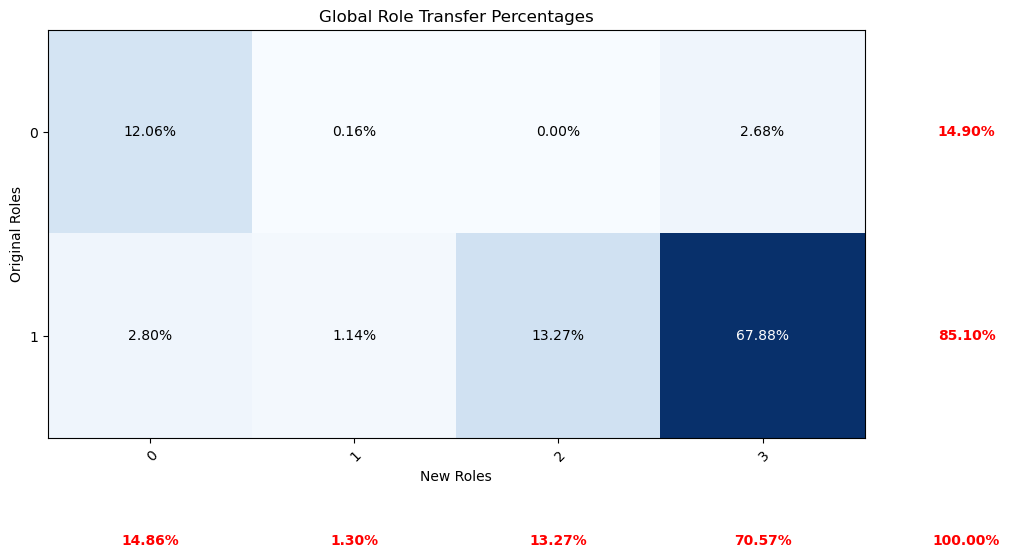

In [3]:
# Plot global role transfer percentages
plot_global_transfer(global_transfer)

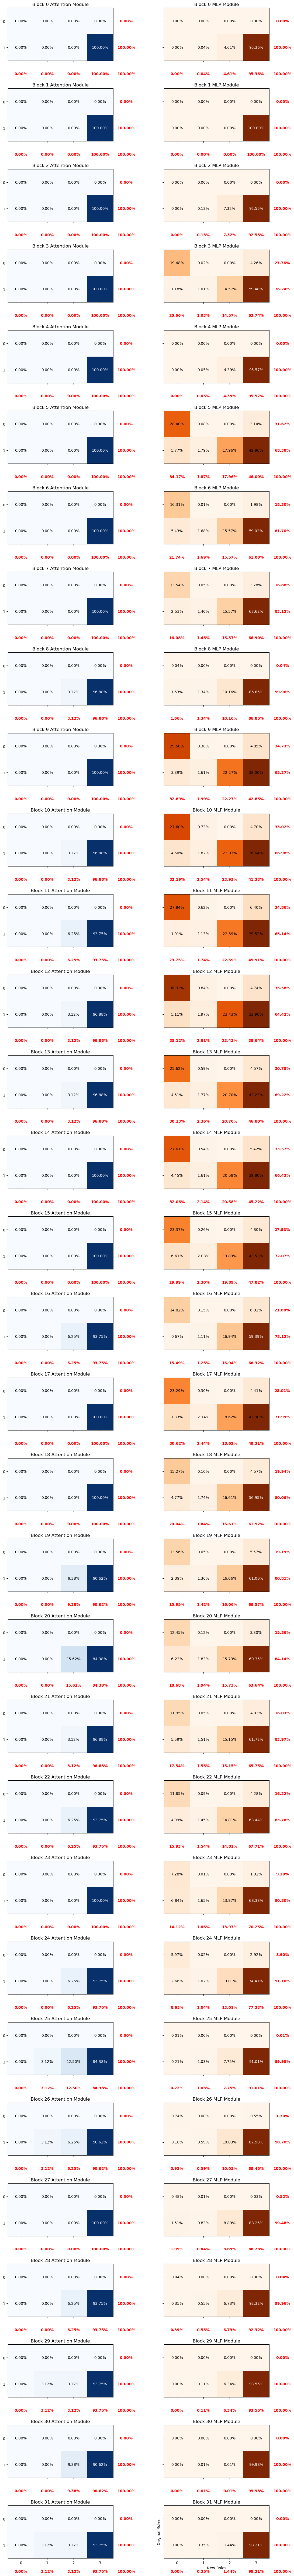

In [4]:
def plot_block_transfer(block_transfer_att, block_transfer_mlp):
    num_blocks = block_transfer_att.shape[0]
    fig, axes = plt.subplots(num_blocks, 2, figsize=(12, 3 * num_blocks), gridspec_kw={'width_ratios': [1, 1]}, sharex=True, sharey=True)

    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']

    def add_sums(matrix, ax):
        total_rows = matrix.sum(axis=1)
        total_cols = matrix.sum(axis=0)

        for i in range(matrix.shape[0]):
            ax.text(matrix.shape[1], i, f'{total_rows[i]:.2%}', va='center', ha='center', color='red', fontweight='bold')

        for j in range(matrix.shape[1]):
            ax.text(j, matrix.shape[0], f'{total_cols[j]:.2%}', va='center', ha='center', color='red', fontweight='bold')

        ax.text(matrix.shape[1], matrix.shape[0], f'{matrix.sum():.2%}', va='center', ha='center', color='red', fontweight='bold')

    if num_blocks == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one block

    for i in range(num_blocks):
        # Plot for Attention Module
        im_att = axes[i, 0].imshow(block_transfer_att[i].numpy(), cmap="Blues")
        axes[i, 0].set_xticks(np.arange(len(new_roles)))
        axes[i, 0].set_yticks(np.arange(len(roles)))
        axes[i, 0].set_xticklabels(new_roles)
        axes[i, 0].set_yticklabels(roles)
        axes[i, 0].set_title(f"Block {i} Attention Module")

        for j in range(len(roles)):
            for k in range(len(new_roles)):
                color = "white" if block_transfer_att[i, j, k] > 0.5 else "black"
                axes[i, 0].text(k, j, f'{block_transfer_att[i, j, k]:.2%}',
                                ha="center", va="center", color=color)

        add_sums(block_transfer_att[i], axes[i, 0])

        # Plot for MLP Module
        im_mlp = axes[i, 1].imshow(block_transfer_mlp[i].numpy(), cmap="Oranges")
        axes[i, 1].set_xticks(np.arange(len(new_roles)))
        axes[i, 1].set_yticks(np.arange(len(roles)))
        axes[i, 1].set_xticklabels(new_roles)
        axes[i, 1].set_yticklabels(roles)
        axes[i, 1].set_title(f"Block {i} MLP Module")

        for j in range(len(roles)):
            for k in range(len(new_roles)):
                color = "white" if block_transfer_mlp[i, j, k] > 0.5 else "black"
                axes[i, 1].text(k, j, f'{block_transfer_mlp[i, j, k]:.2%}',
                                ha="center", va="center", color=color)

        add_sums(block_transfer_mlp[i], axes[i, 1])

    fig.tight_layout(pad=2.0)
    plt.xlabel('New Roles')
    plt.ylabel('Original Roles')
    plt.show()


# Plot block level role transfer percentages
plot_block_transfer(block_transfer_att, block_transfer_mlp)

In [5]:
def plot_module_transfer(att_transfer, mlp_transfer):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    roles = ['0', '1']
    new_roles = ['0', '1', '2', '3']

    def add_sums(matrix, ax):
        total_rows = matrix.sum(axis=1)
        total_cols = matrix.sum(axis=0)

        for i in range(matrix.shape[0]):
            ax.text(matrix.shape[1], i, f'{total_rows[i]:.2%}', va='center', ha='center', color='red', fontweight='bold')

        for j in range(matrix.shape[1]):
            ax.text(j, matrix.shape[0], f'{total_cols[j]:.2%}', va='center', ha='center', color='red', fontweight='bold')

        ax.text(matrix.shape[1], matrix.shape[0], f'{matrix.sum():.2%}', va='center', ha='center', color='red', fontweight='bold')

    # Plot for Attention Module
    im_att = axes[0].imshow(att_transfer.numpy(), cmap="Blues")
    axes[0].set_xticks(np.arange(len(new_roles)))
    axes[0].set_yticks(np.arange(len(roles)))
    axes[0].set_xticklabels(new_roles)
    axes[0].set_yticklabels(roles)
    axes[0].set_title("Attention Module Role Transfer")
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if att_transfer[i, j] > 0.5 else "black"
            axes[0].text(j, i, f'{att_transfer[i, j]:.2%}', ha="center", va="center", color=color)

    add_sums(att_transfer, axes[0])

    # Plot for MLP Module
    im_mlp = axes[1].imshow(mlp_transfer.numpy(), cmap="Oranges")
    axes[1].set_xticks(np.arange(len(new_roles)))
    axes[1].set_yticks(np.arange(len(roles)))
    axes[1].set_xticklabels(new_roles)
    axes[1].set_yticklabels(roles)
    axes[1].set_title("MLP Module Role Transfer")
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(roles)):
        for j in range(len(new_roles)):
            color = "white" if mlp_transfer[i, j] > 0.5 else "black"
            axes[1].text(j, i, f'{mlp_transfer[i, j]:.2%}', ha="center", va="center", color=color)

    add_sums(mlp_transfer, axes[1])

    fig.tight_layout()
    plt.xlabel('New Roles')
    plt.ylabel('Original Roles')
    plt.show()

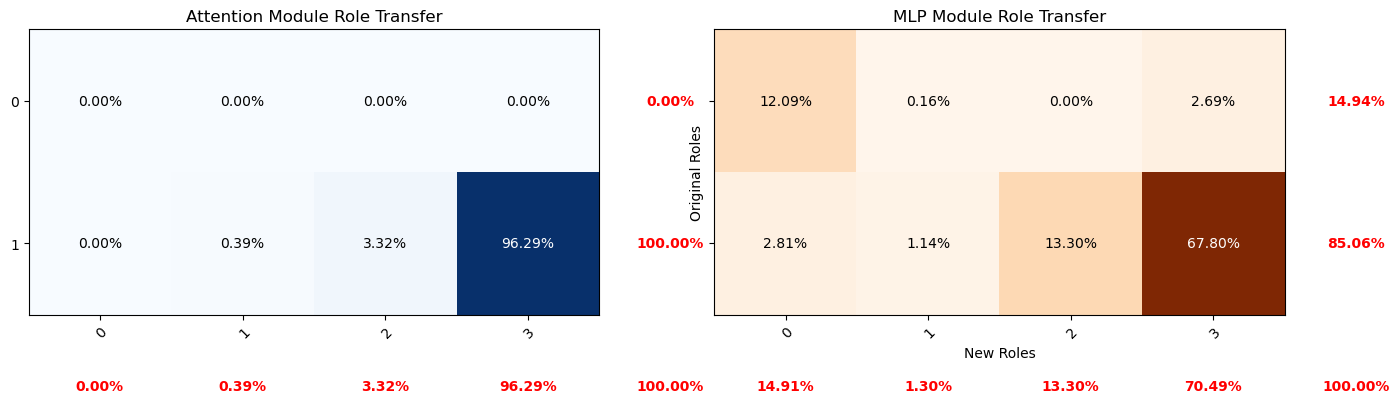

In [6]:
# Plot module level role transfer percentages
plot_module_transfer(att_transfer, mlp_transfer)

In [7]:
import matplotlib.pyplot as plt

def plot_role_transfers_over_blocks(block_transfer_att, block_transfer_mlp, transfers_to_show):
    num_blocks = block_transfer_att.shape[0]

    # Plot for Attention Module
    # fig, ax = plt.subplots(figsize=(14, 8))
    # for role, new_role in transfers_to_show:
    #     transfer_rates = block_transfer_att[:, role, new_role].numpy()
    #     ax.plot(range(num_blocks), transfer_rates, label=f'Role {role} -> {new_role}', marker='o')

    # ax.set_title('Attention Module Role Transfers Over Blocks')
    # ax.set_xlabel('Block Index')
    # ax.set_ylabel('Transfer Rate')
    # ax.legend()
    # plt.show()

    # Plot for MLP Module
    fig, ax = plt.subplots(figsize=(14, 8))
    for role, new_role in transfers_to_show:
        transfer_rates = block_transfer_mlp[:, role, new_role].numpy()
        ax.plot(range(num_blocks), transfer_rates, label=f'Role {role} -> {new_role}', marker='o')

    ax.set_title('MLP Module Role Transfers Over Blocks')
    ax.set_xlabel('Block Index')
    ax.set_ylabel('Transfer Rate')
    ax.legend()
    plt.show()


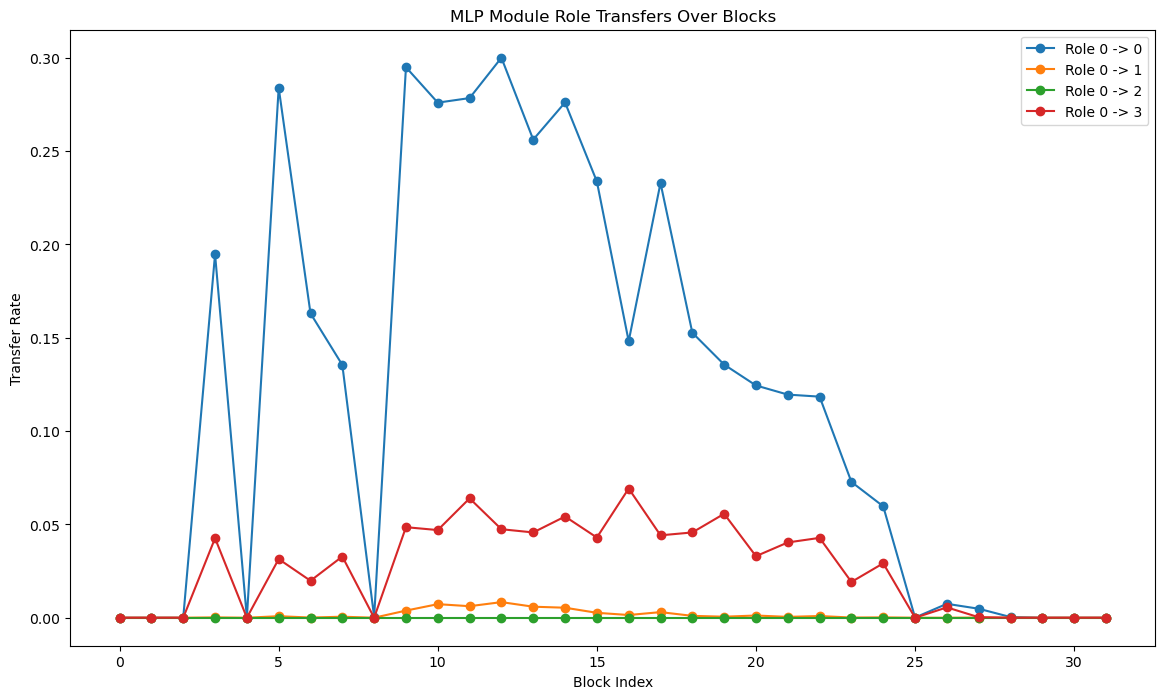

In [8]:
# Define the transfers you want to show, e.g., [(0, 1), (1, 2)]
# transfers_to_show = [(0, 0), (1, 2), (0, 3)]
transfers_to_show = [(0, 0),(0, 1), (0, 2), (0, 3)]

# Example call
plot_role_transfers_over_blocks(block_transfer_att, block_transfer_mlp, transfers_to_show)

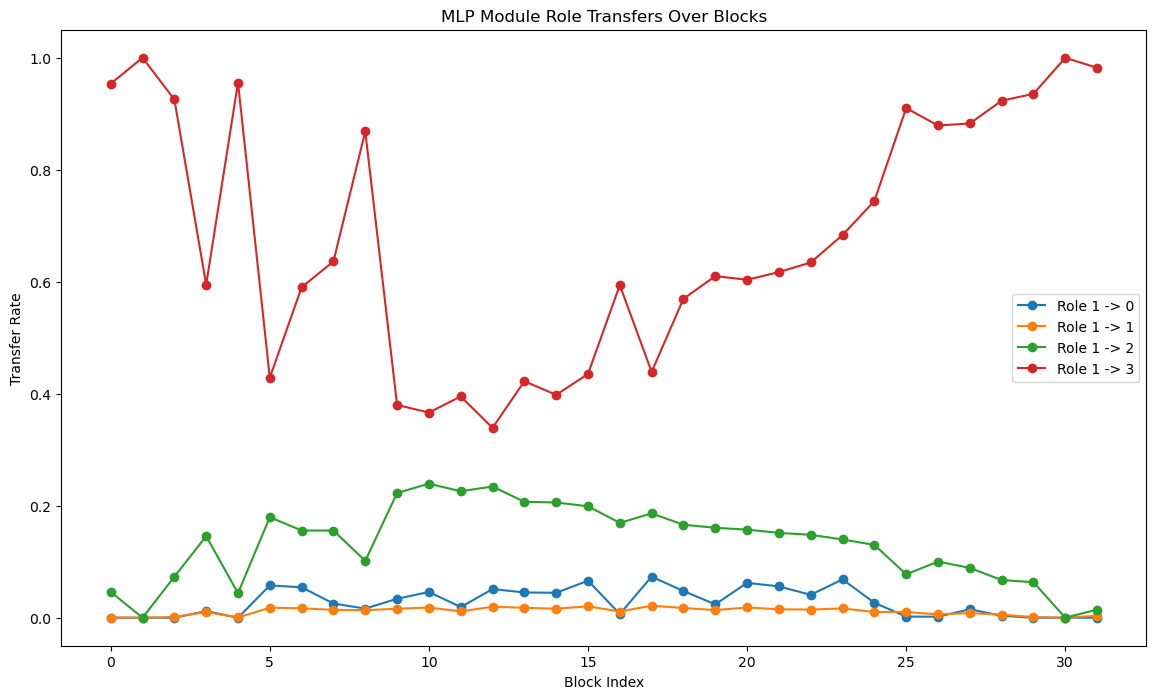

In [9]:
transfers_to_show = [(1, 0),(1, 1), (1, 2), (1, 3)]

# Example call
plot_role_transfers_over_blocks(block_transfer_att, block_transfer_mlp, transfers_to_show)

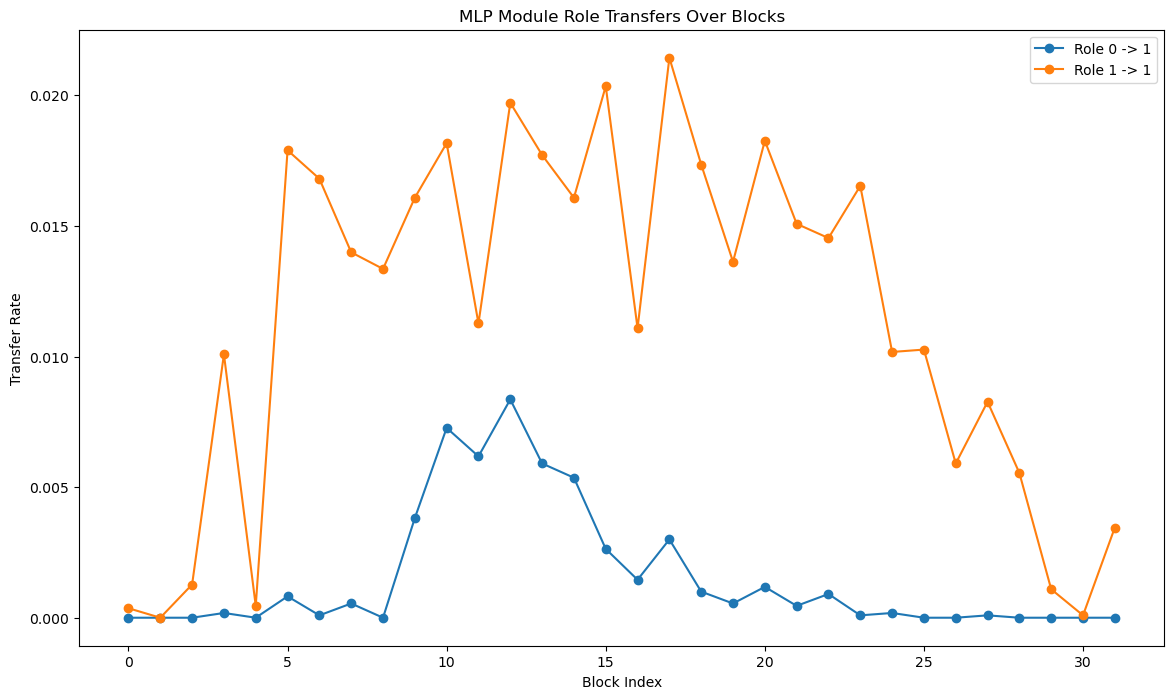

In [10]:
transfers_to_show = [(0, 1),(1, 1)]

# Example call
plot_role_transfers_over_blocks(block_transfer_att, block_transfer_mlp, transfers_to_show)

In [11]:
def plot_role_transfer_pie_charts(block_transfer_att, block_transfer_mlp, role):
    num_blocks = block_transfer_att.shape[0]
    new_roles = ['0', '1', '2', '3']

    # Define custom color maps
    colors_att = ['#08306B', '#08519C', '#2171B5', '#4292C6']
    colors_mlp = ['#7F2704', '#A63603', '#D94801', '#F16913']

    def plot_pie_chart(ax, data, labels, colors, title):
        wedges, texts, autotexts = ax.pie(data, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        ax.set_title(title)

        # Add arrows for small slices
        for i, (wedge, text) in enumerate(zip(wedges, autotexts)):
            if data[i] < 0.05:  # Adjust threshold as needed
                text.set_text('')
                x, y = wedge.theta2, wedge.theta1
                angle = (x + y) / 2
                x = np.cos(np.radians(angle))
                y = np.sin(np.radians(angle))
                ax.annotate(f'{data[i]:.2%}', xy=(x, y), xytext=(1.3 * x, 1.3 * y),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'),
                            ha='center')

    # Plot for each block
    for i in range(num_blocks):
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        
        # Attention Module
        transfer_rates_att = block_transfer_att[i, role, :].numpy()
        if transfer_rates_att.sum() > 0:
            plot_pie_chart(ax[0], transfer_rates_att, new_roles, colors_att, f'Block {i} Attention Module Role {role} Transfer')
        else:
            ax[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
            ax[0].set_title(f'Block {i} Attention Module Role {role} Transfer')

        # MLP Module
        transfer_rates_mlp = block_transfer_mlp[i, role, :].numpy()
        if transfer_rates_mlp.sum() > 0:
            plot_pie_chart(ax[1], transfer_rates_mlp, new_roles, colors_mlp, f'Block {i} MLP Module Role {role} Transfer')
        else:
            ax[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
            ax[1].set_title(f'Block {i} MLP Module Role {role} Transfer')

        plt.show()

    # Calculate the average transfer rate for each new role across all blocks for attention module
    avg_transfer_att = block_transfer_att[:, role, :].mean(axis=0).numpy()
    
    # Calculate the average transfer rate for each new role across all blocks for mlp module
    avg_transfer_mlp = block_transfer_mlp[:, role, :].mean(axis=0).numpy()

    # Plot for average transfer rate
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # Attention Module
    if avg_transfer_att.sum() > 0:
        plot_pie_chart(ax[0], avg_transfer_att, new_roles, colors_att, f'Average Attention Module Role {role} Transfer')
    else:
        ax[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
        ax[0].set_title(f'Average Attention Module Role {role} Transfer')

    # MLP Module
    if avg_transfer_mlp.sum() > 0:
        plot_pie_chart(ax[1], avg_transfer_mlp, new_roles, colors_mlp, f'Average MLP Module Role {role} Transfer')
    else:
        ax[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
        ax[1].set_title(f'Average MLP Module Role {role} Transfer')

    plt.show()


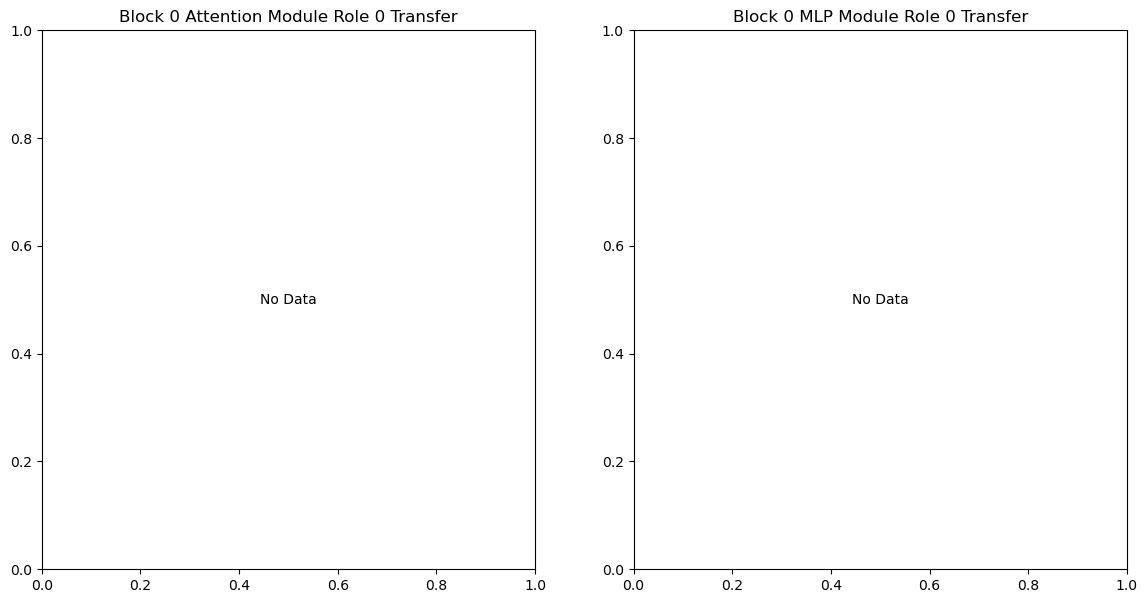

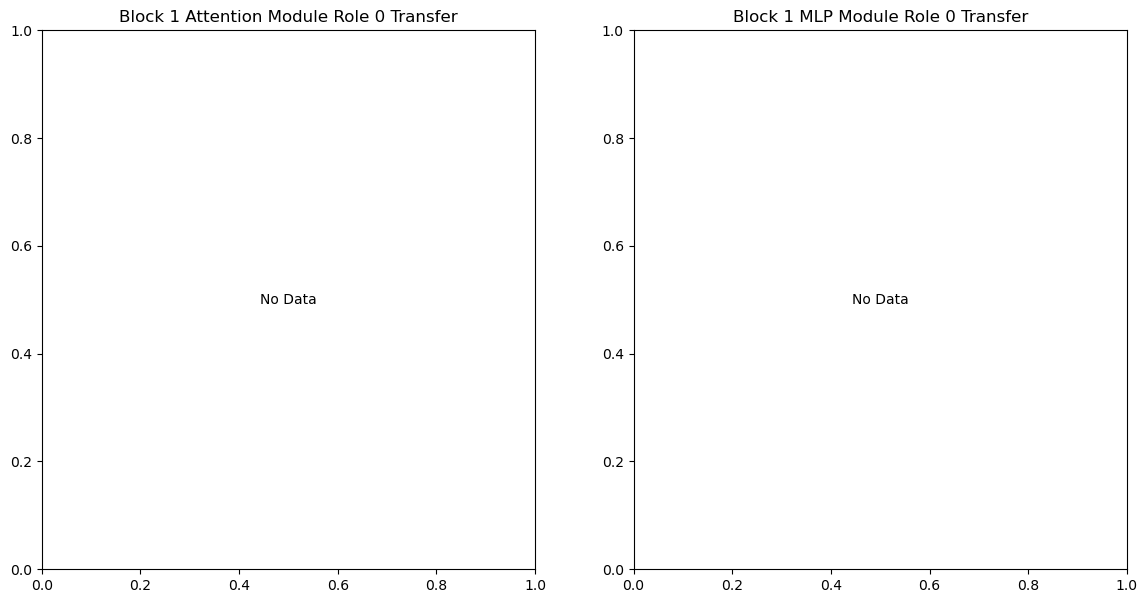

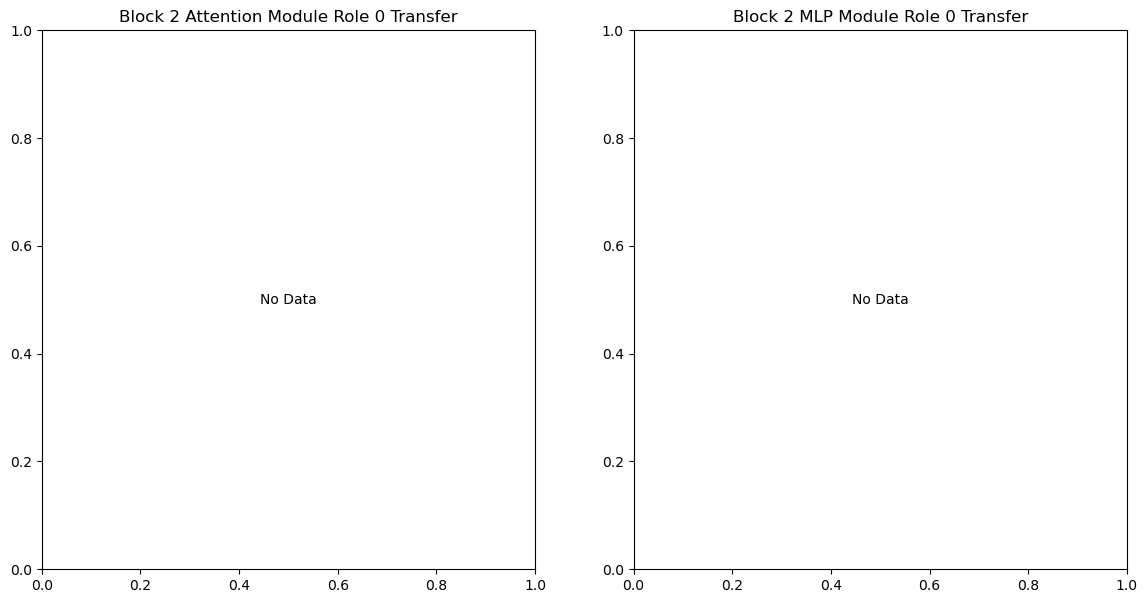

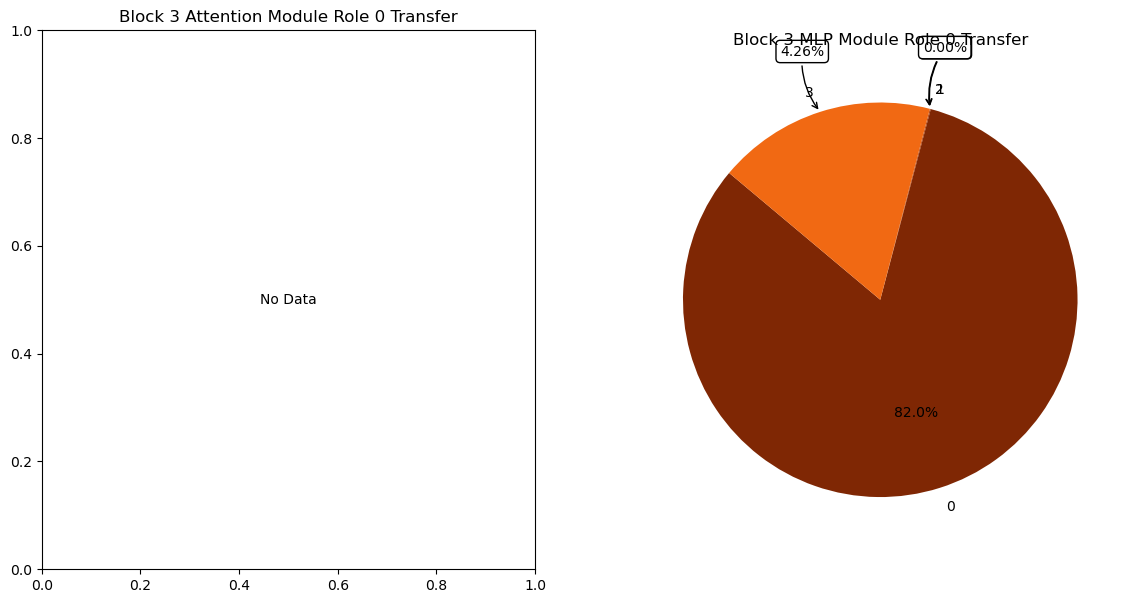

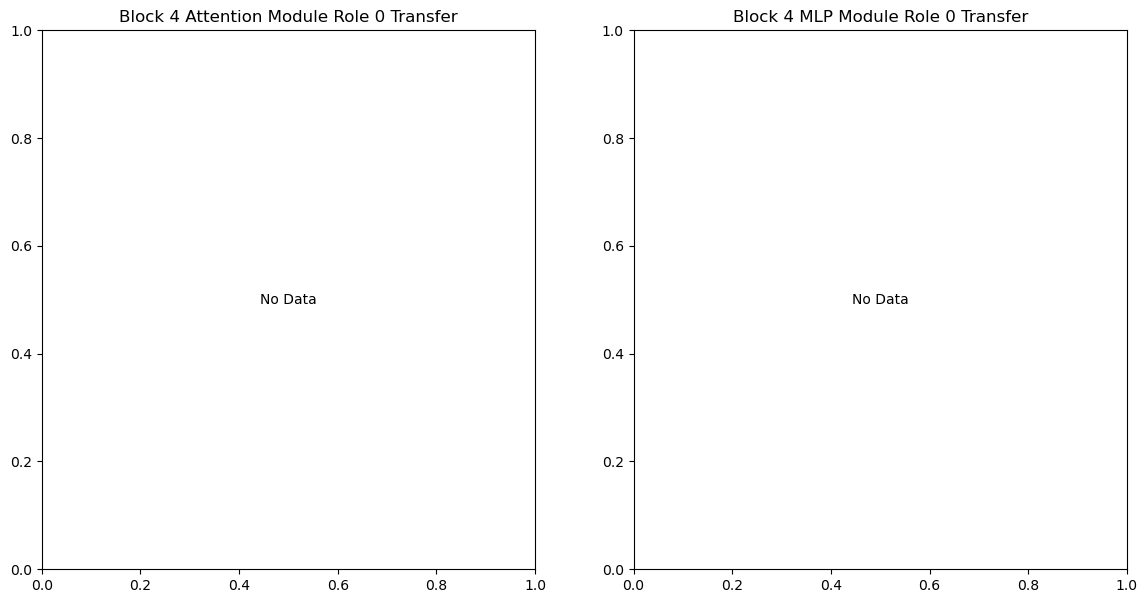

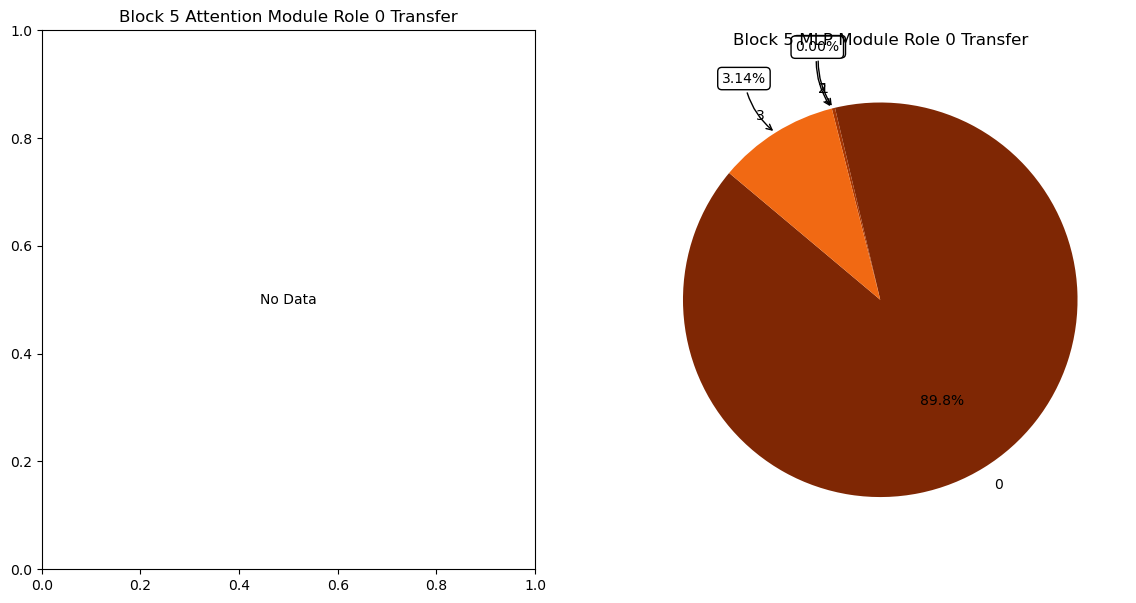

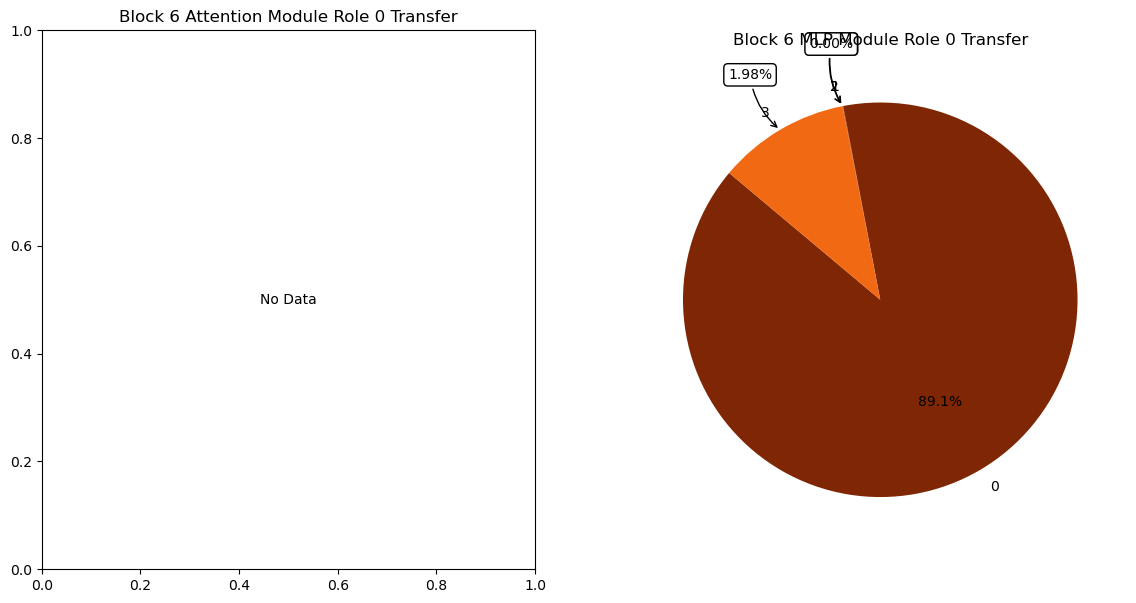

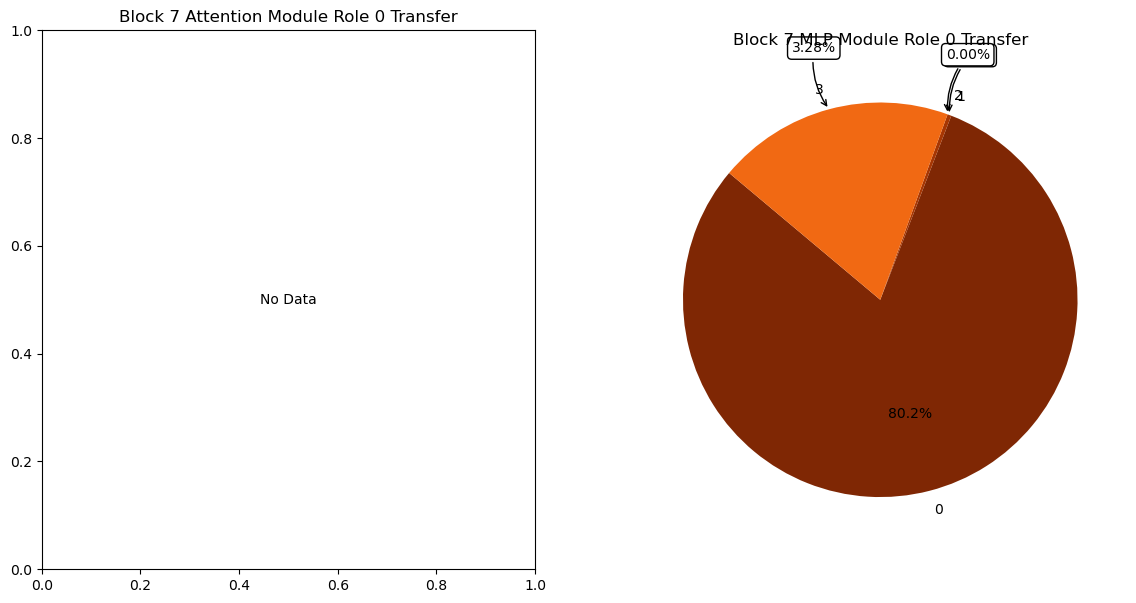

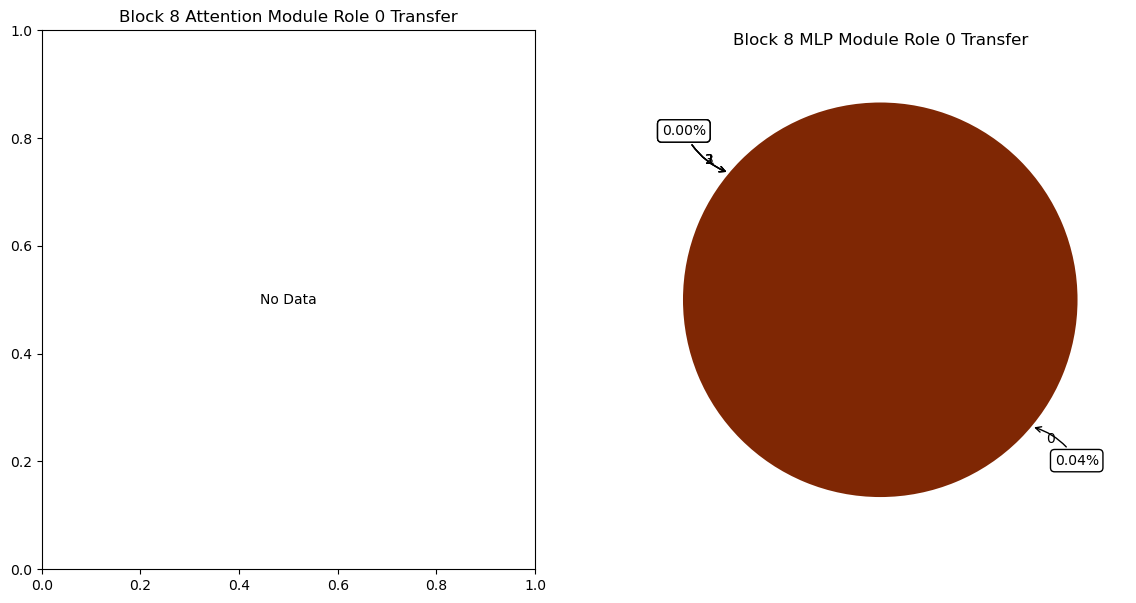

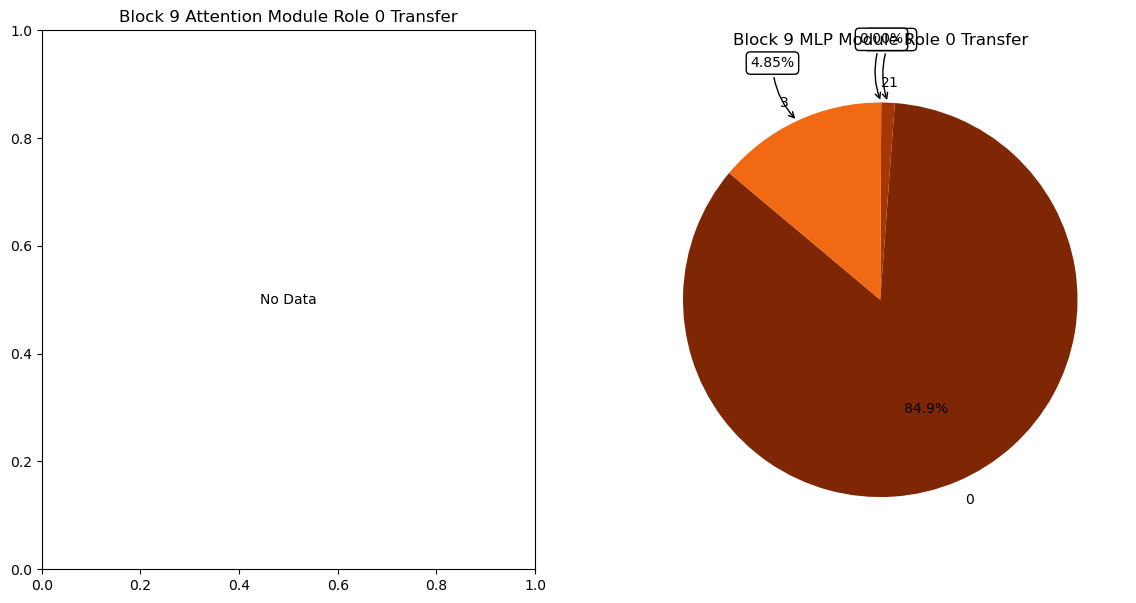

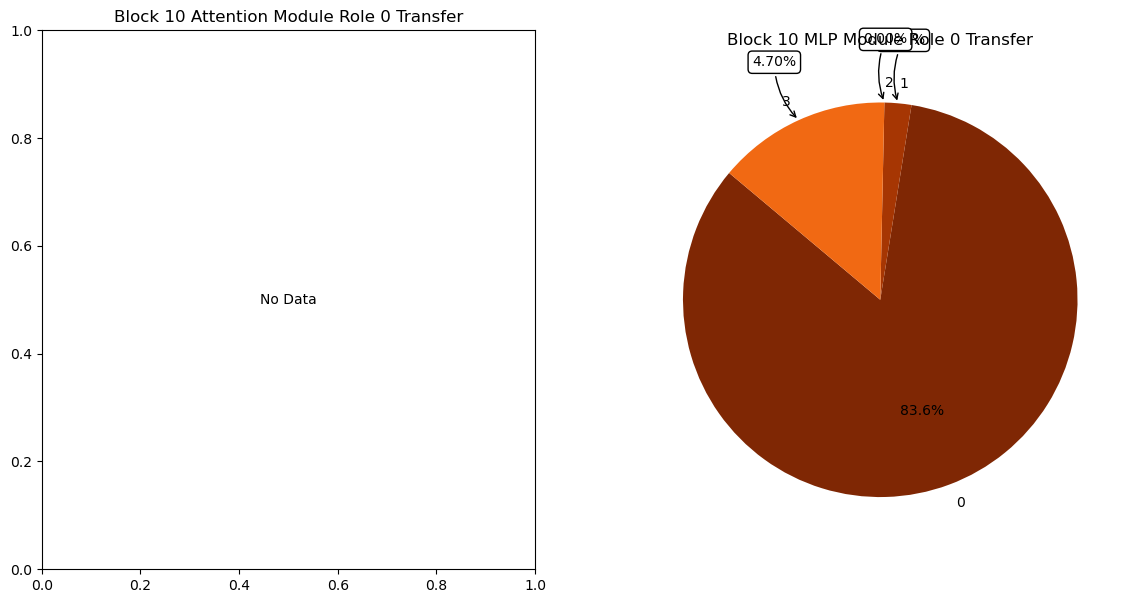

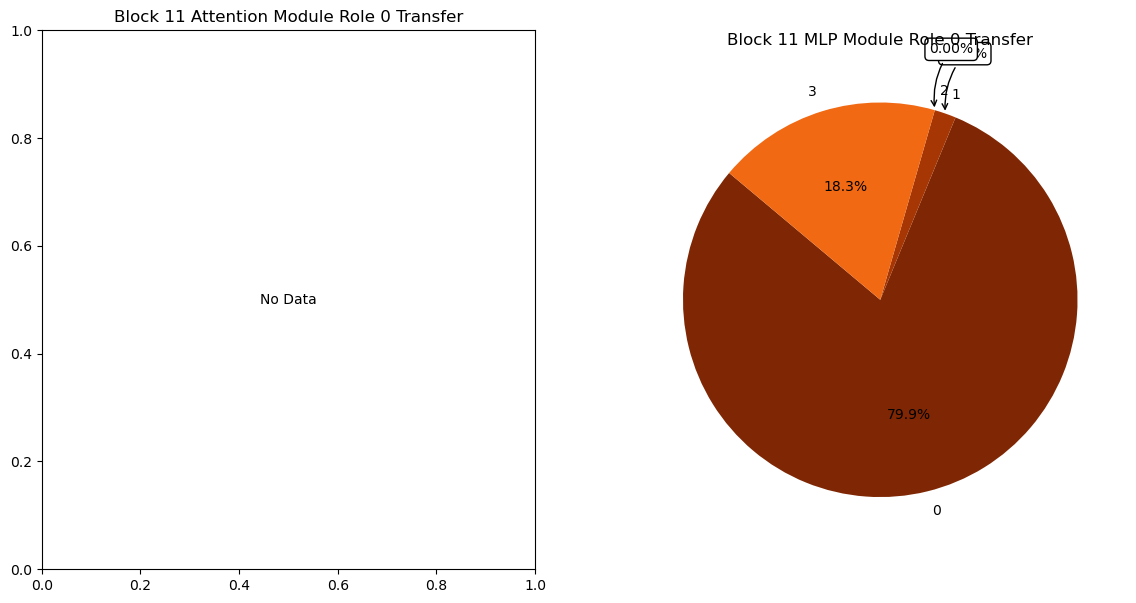

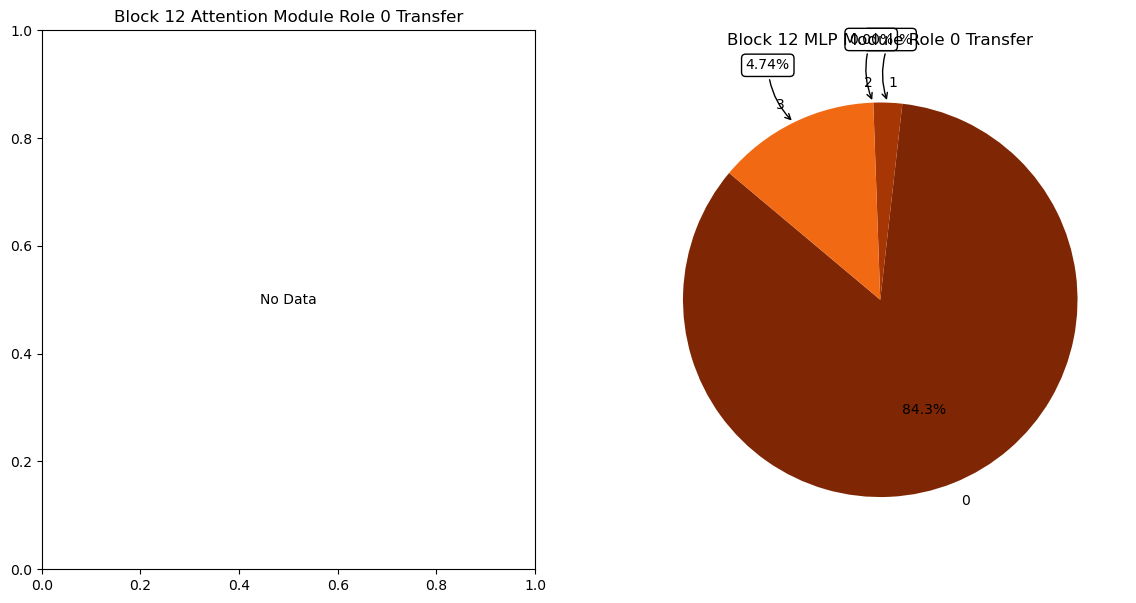

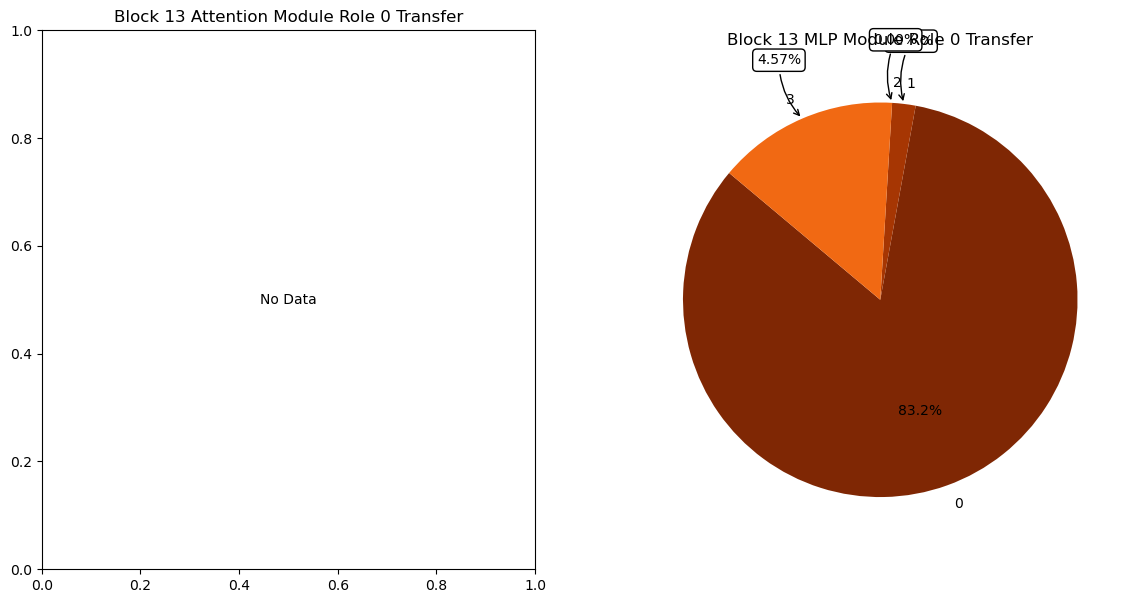

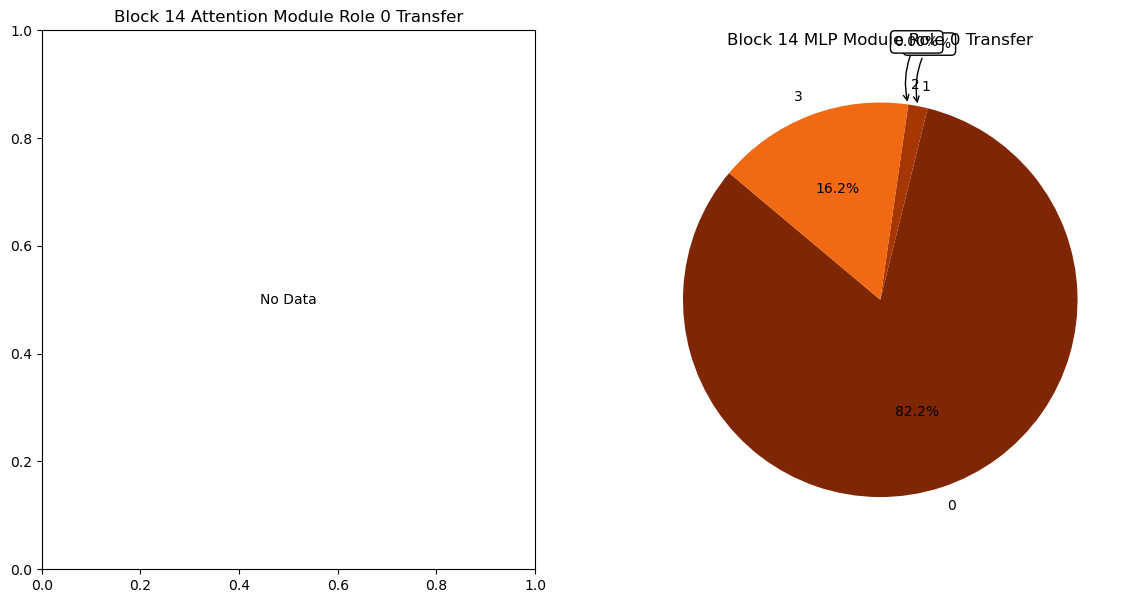

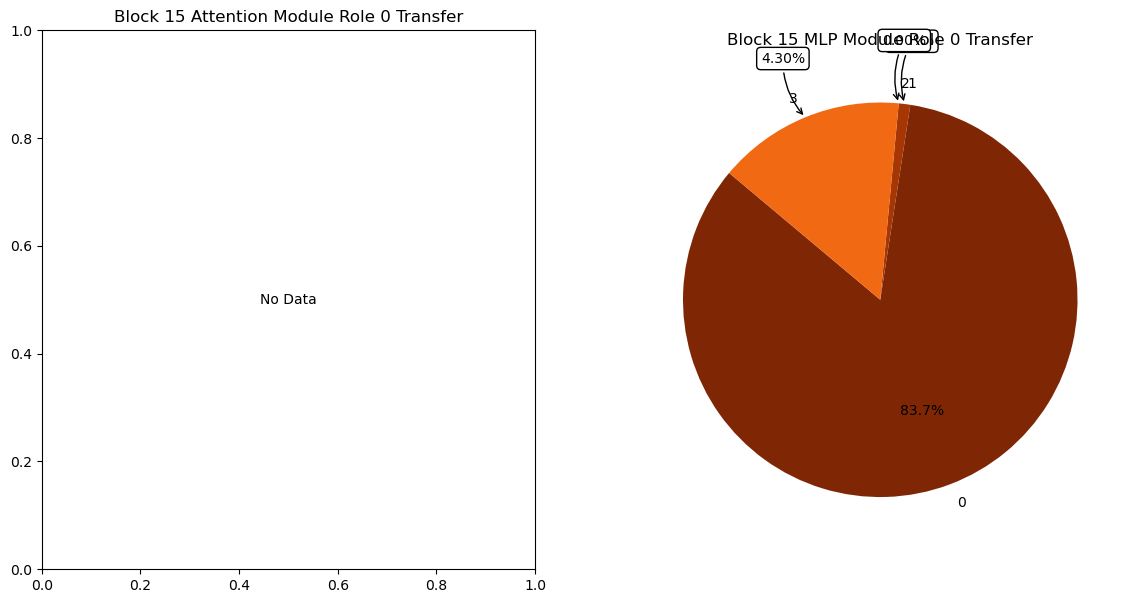

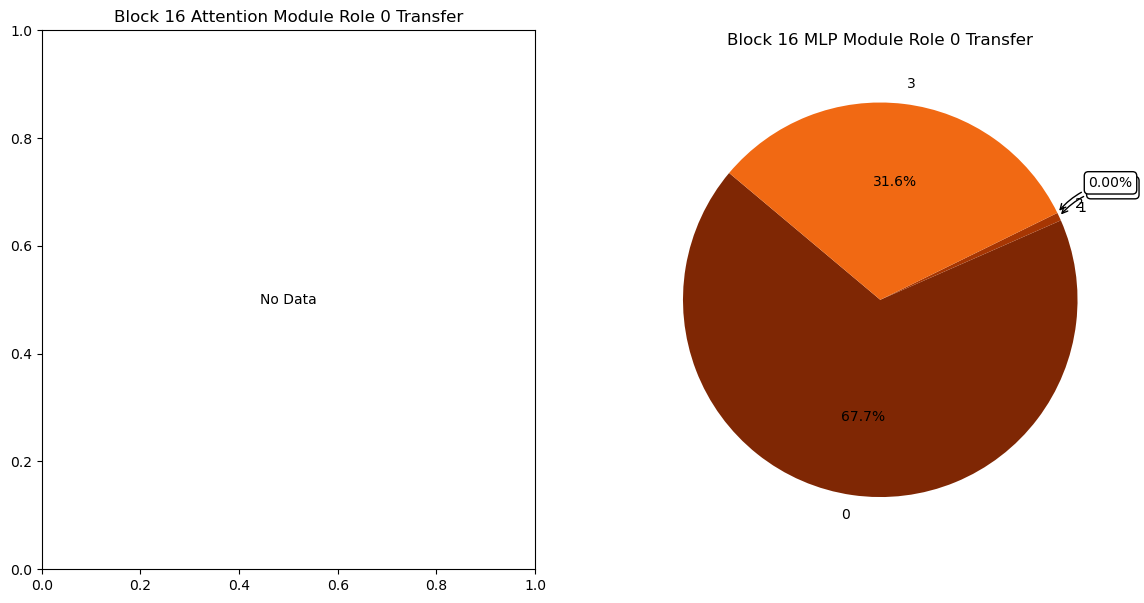

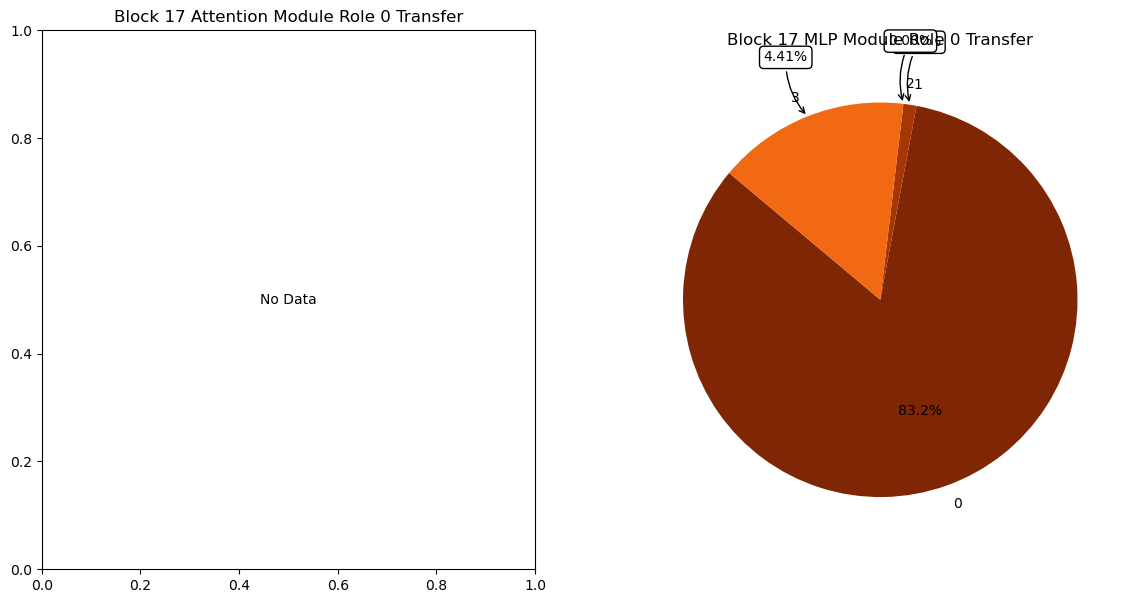

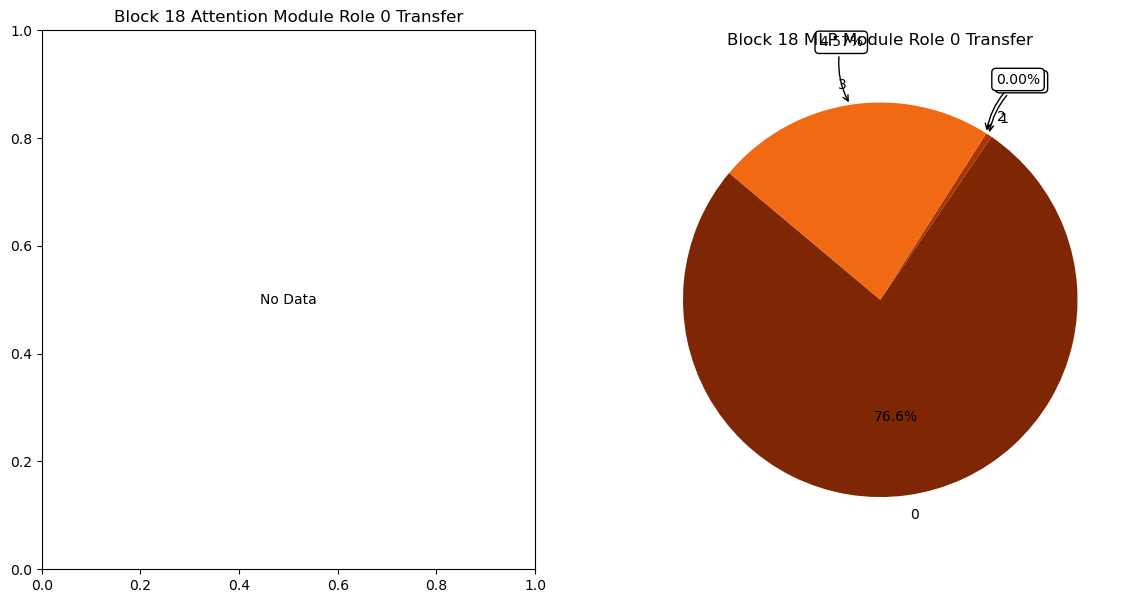

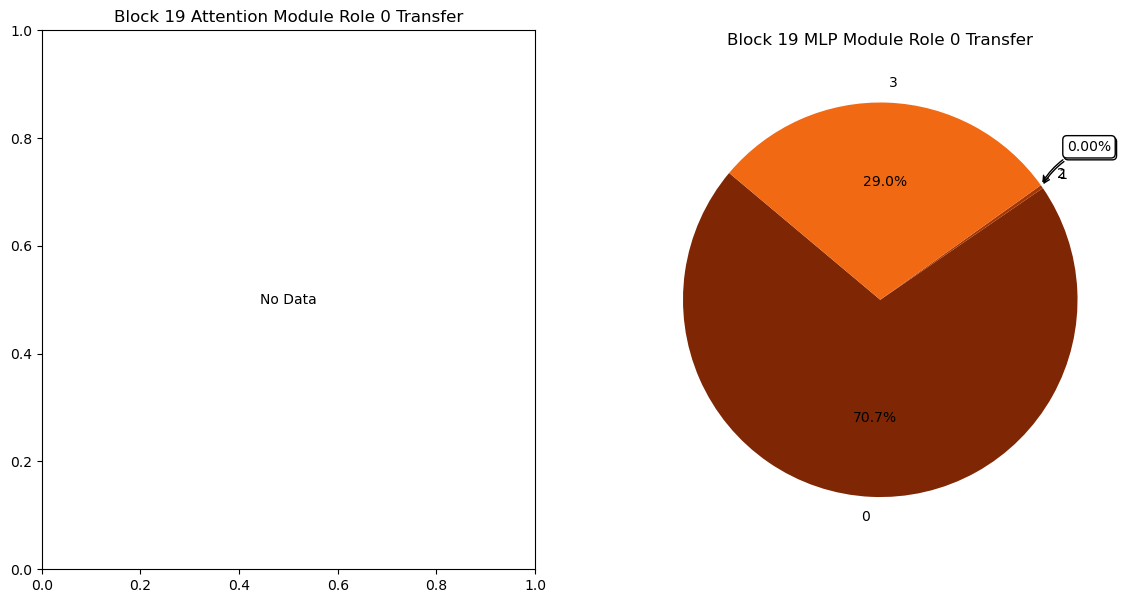

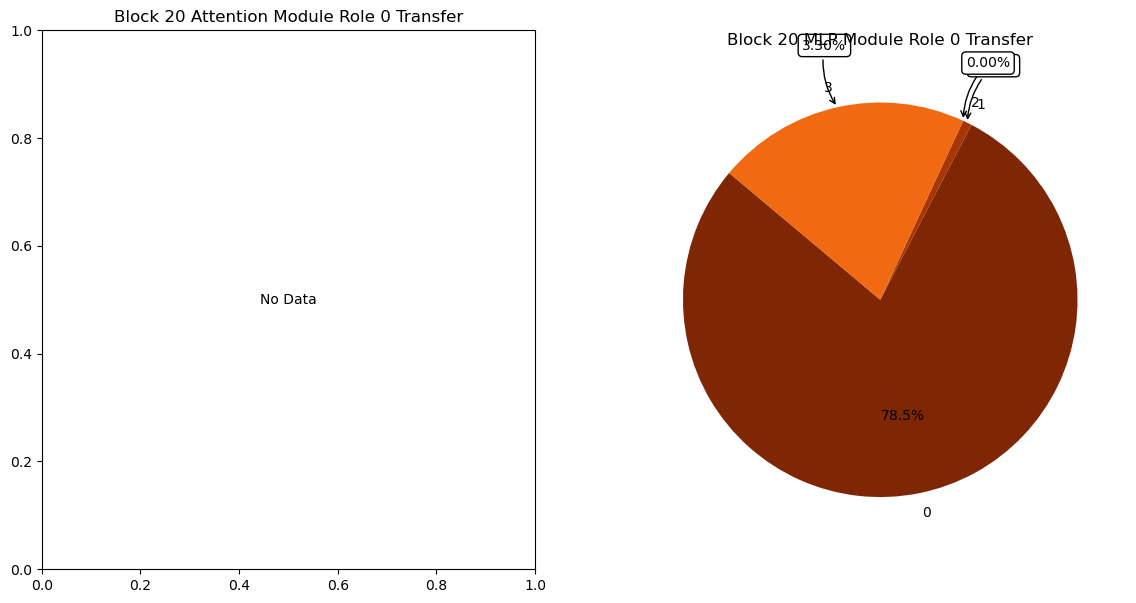

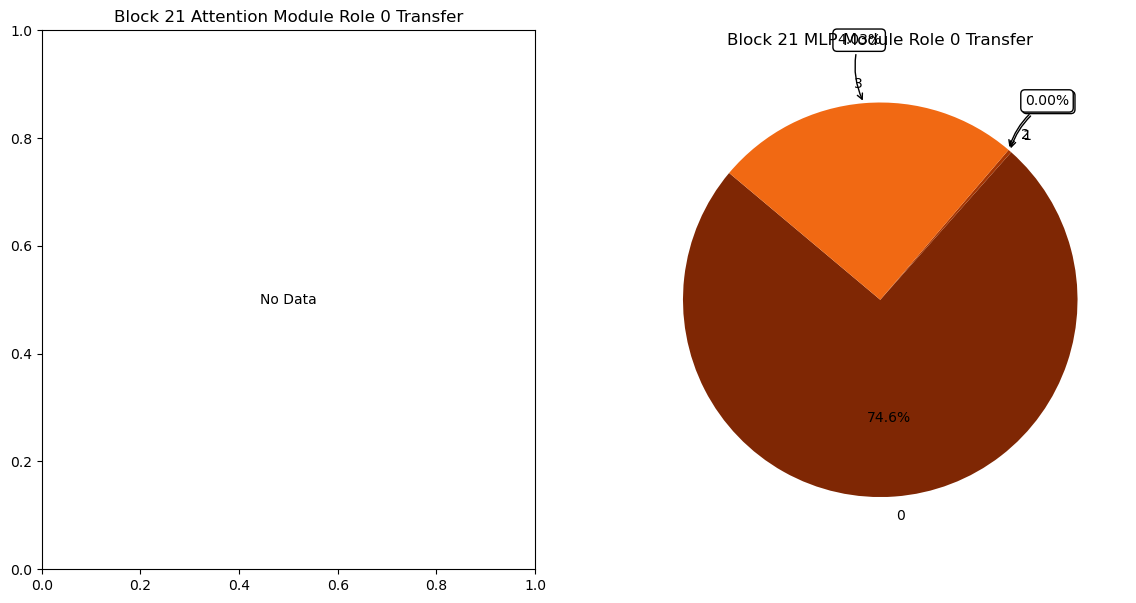

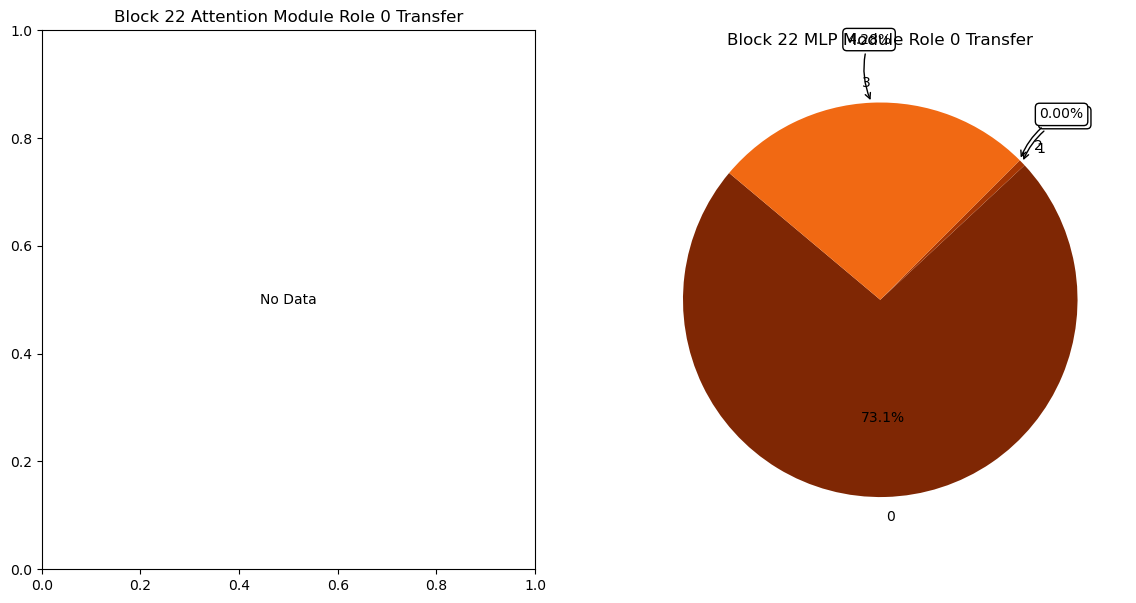

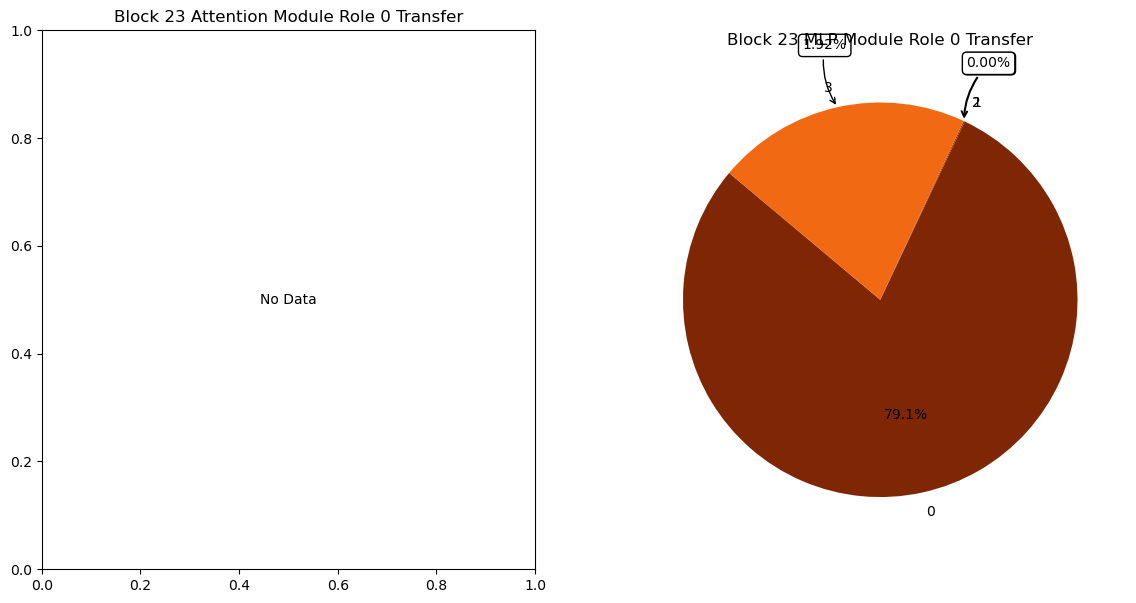

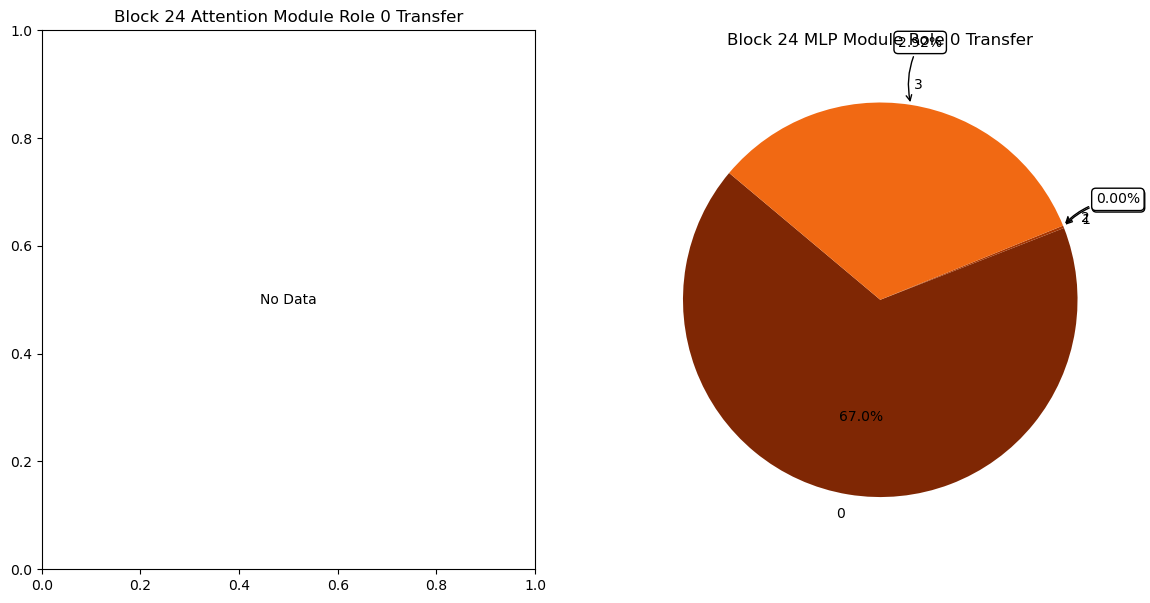

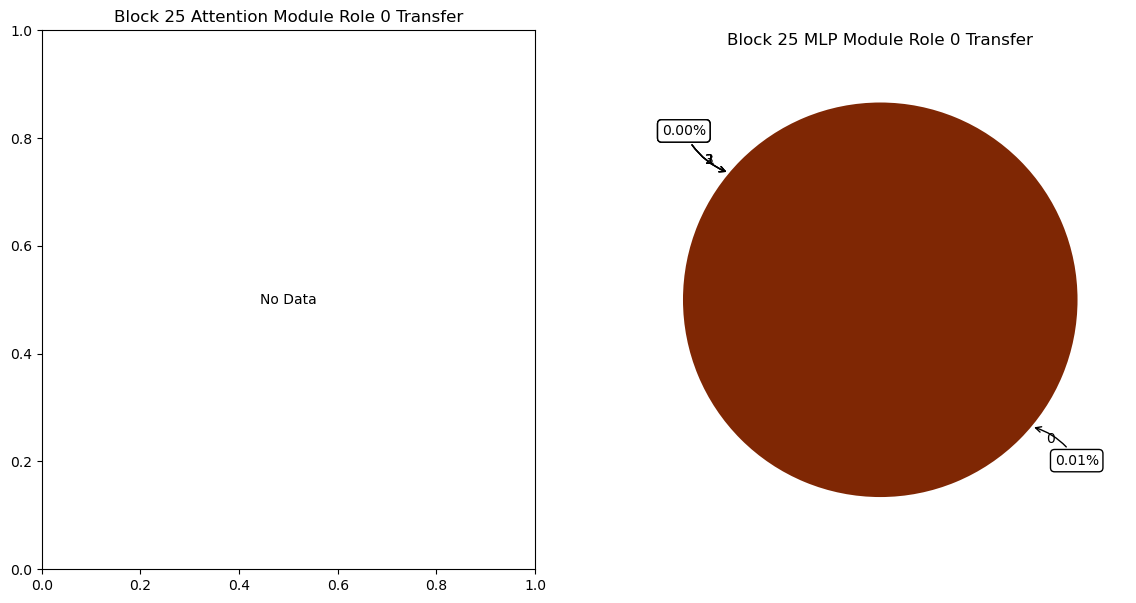

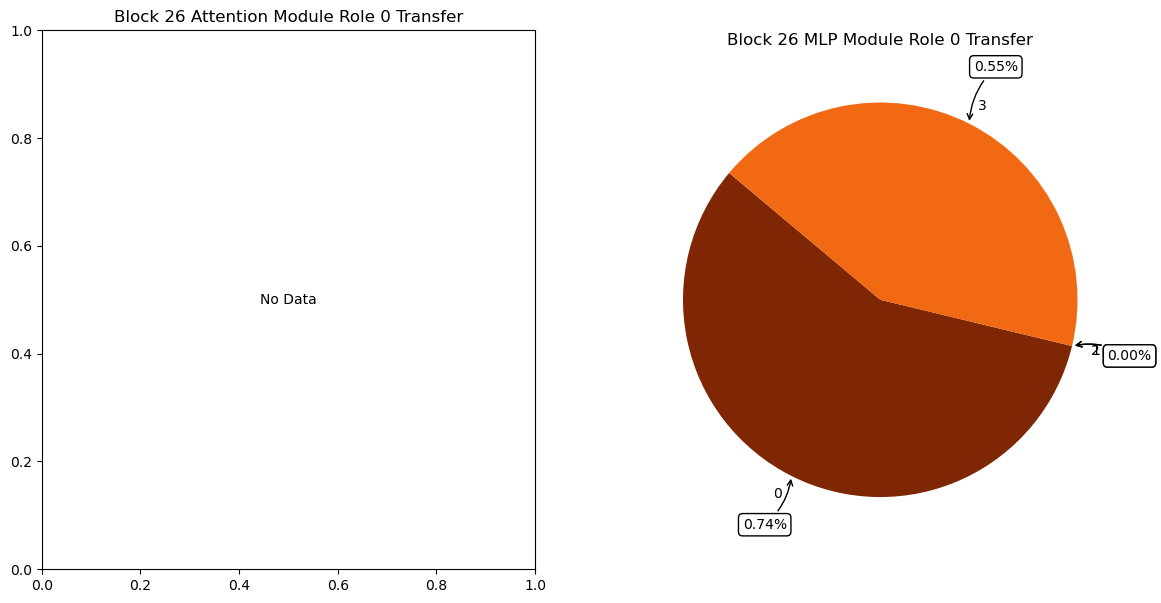

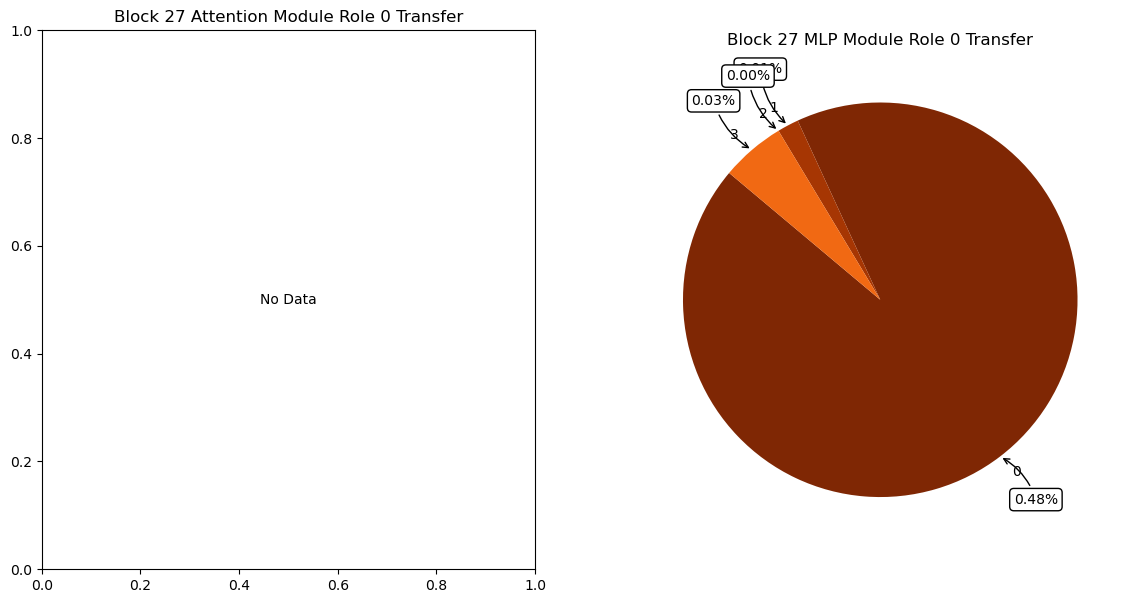

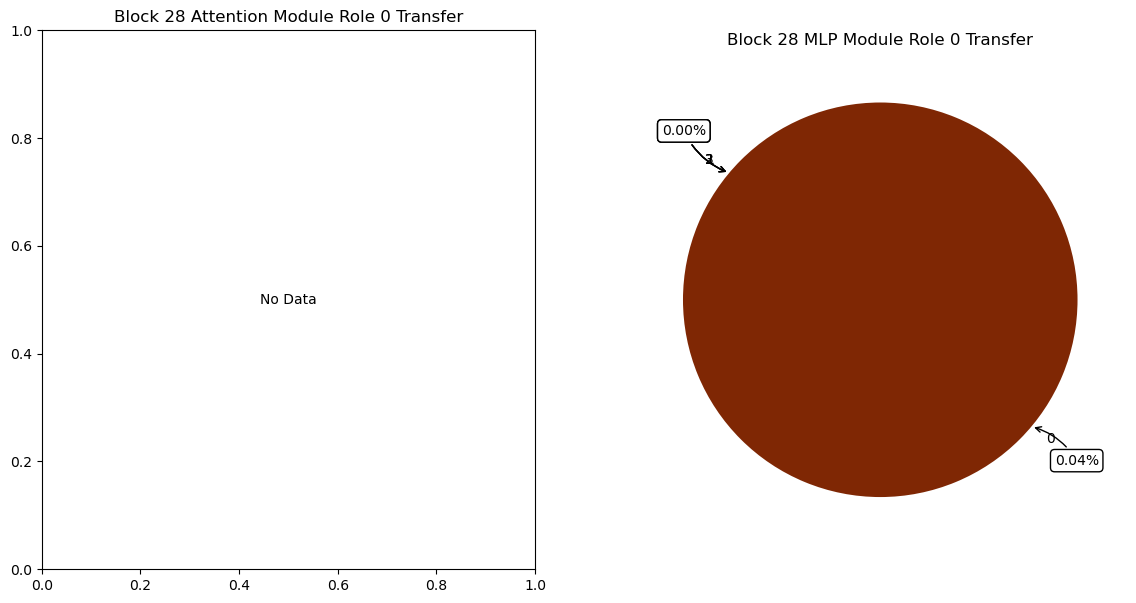

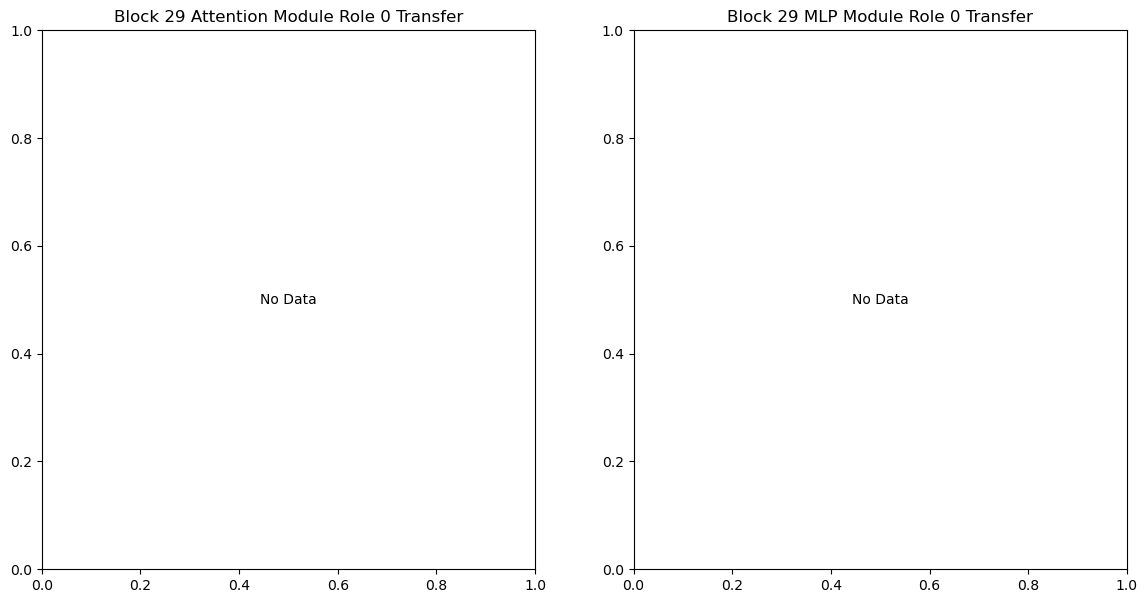

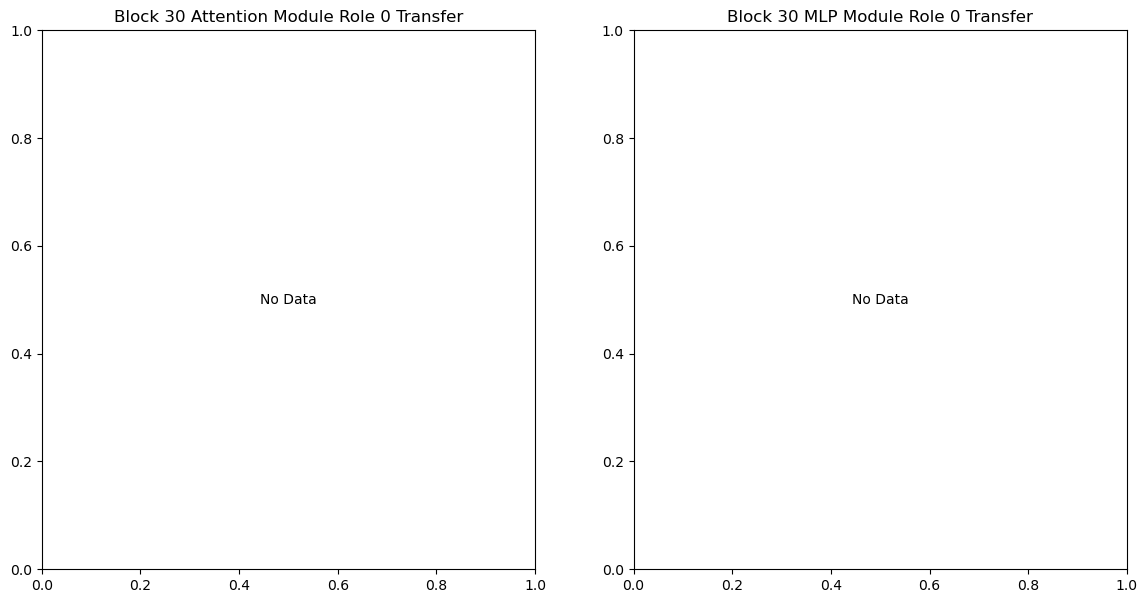

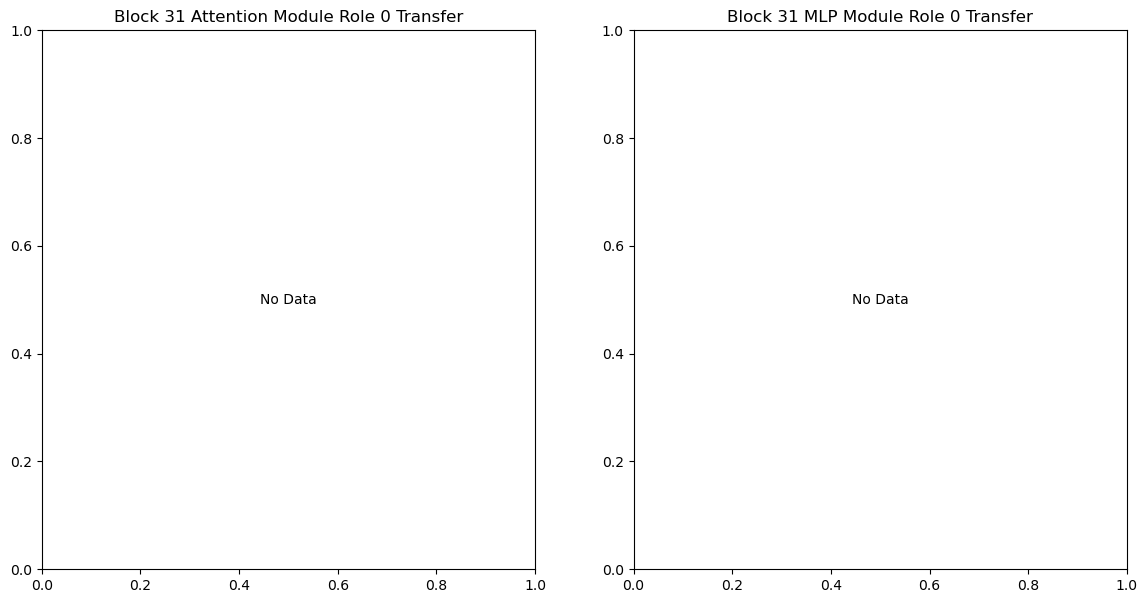

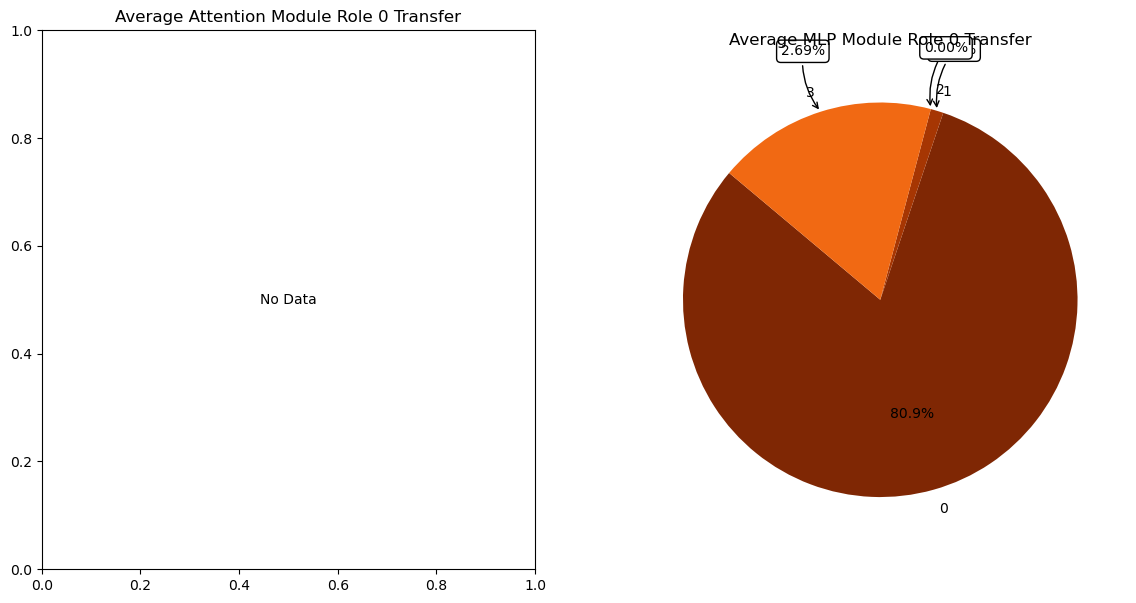

In [12]:
plot_role_transfer_pie_charts(block_transfer_att, block_transfer_mlp, role=0)


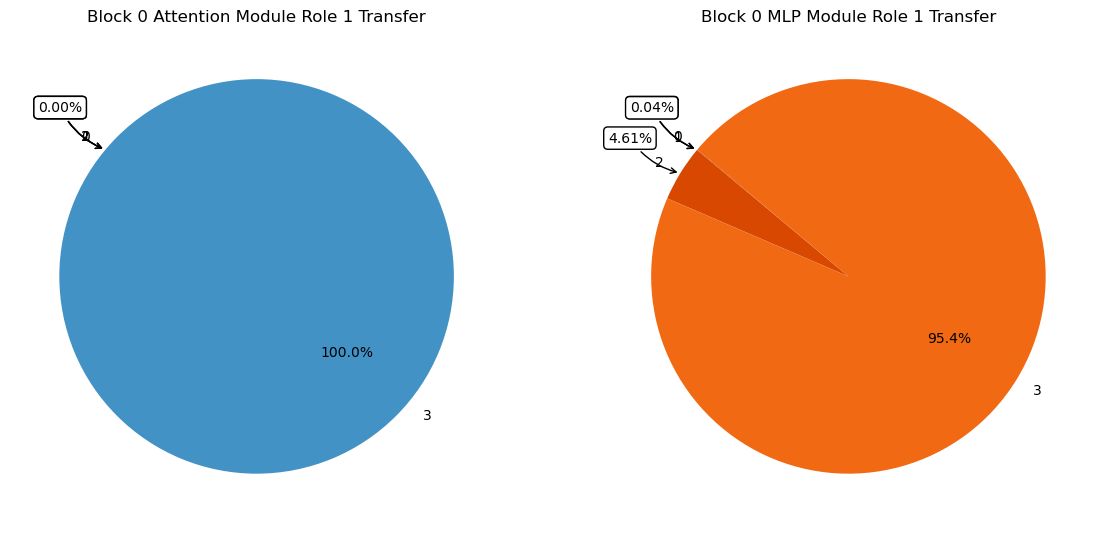

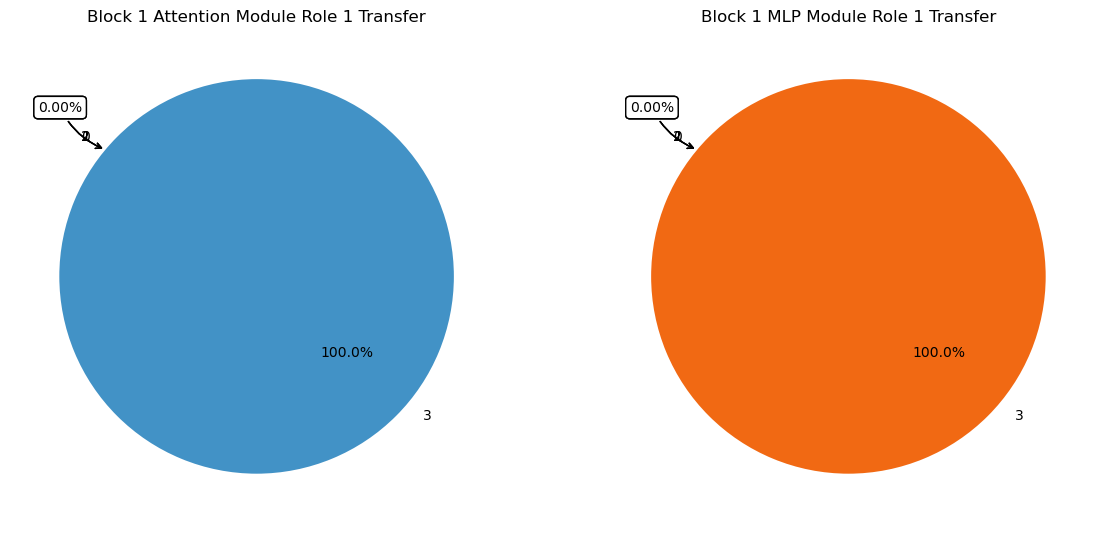

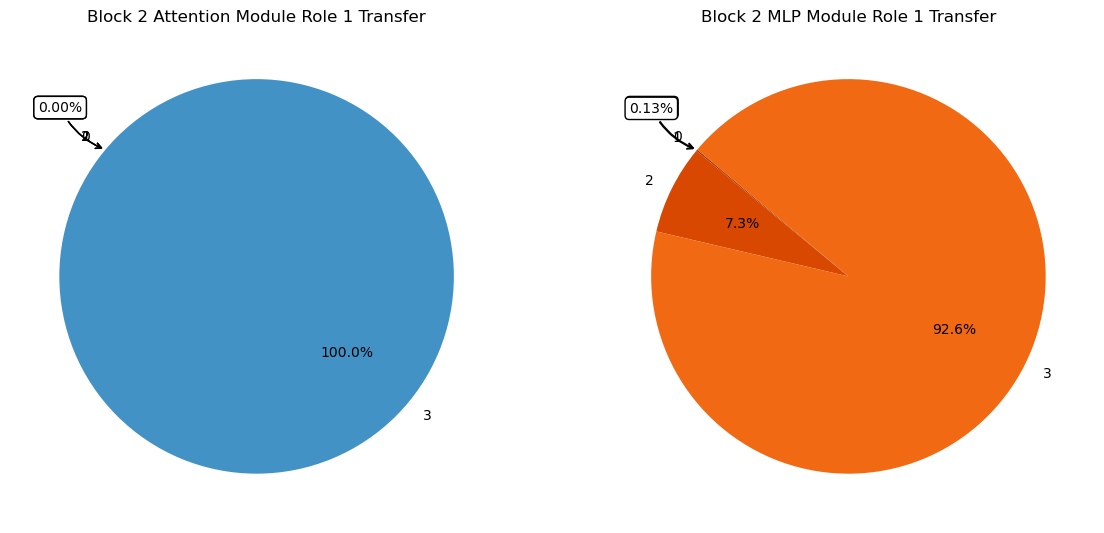

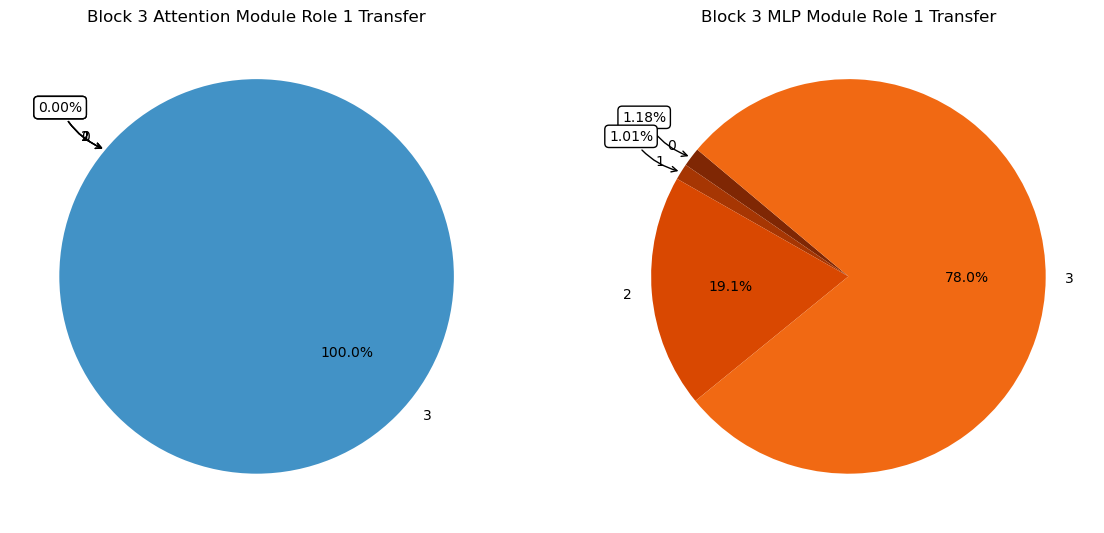

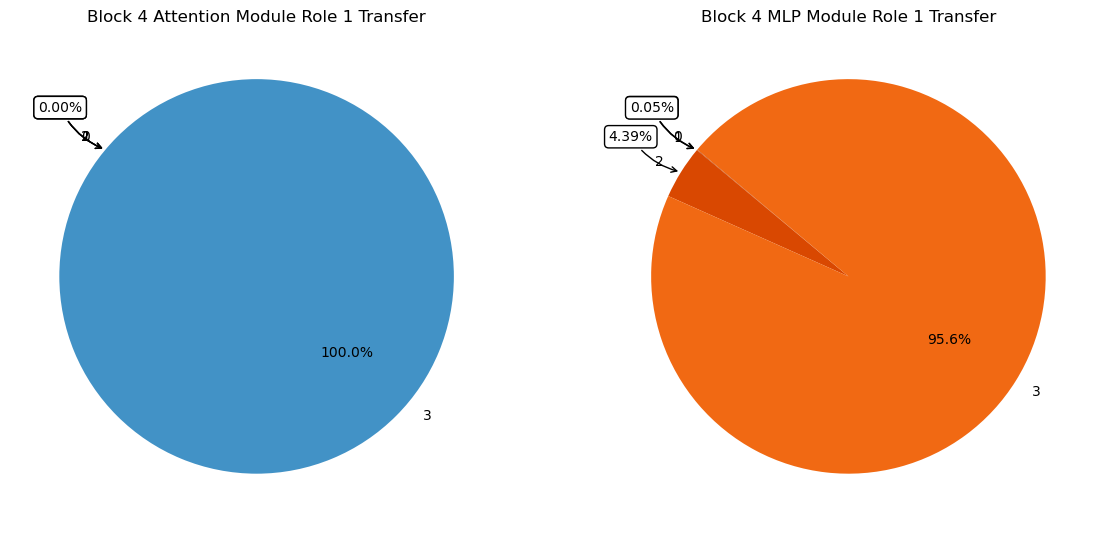

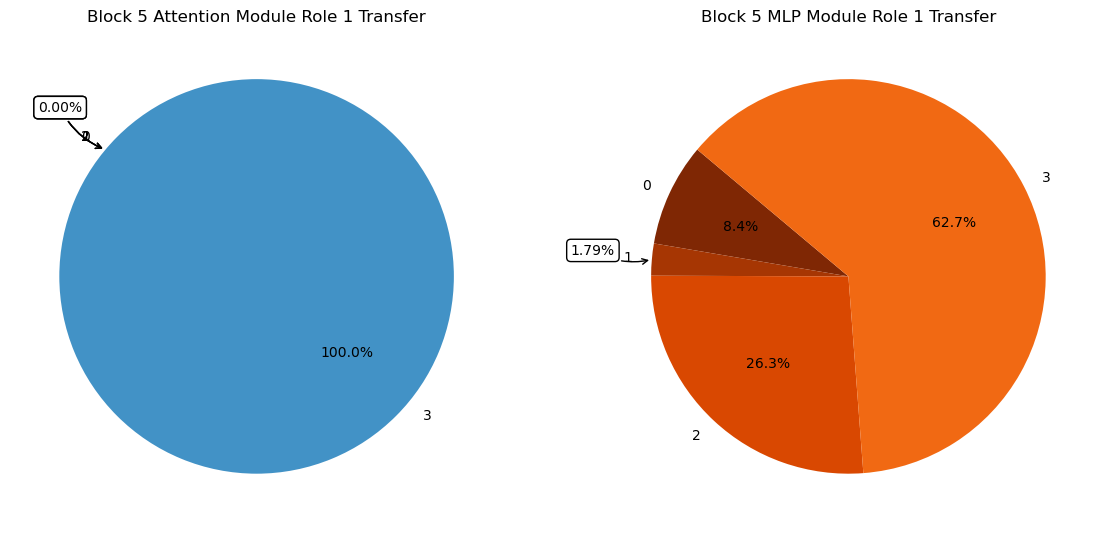

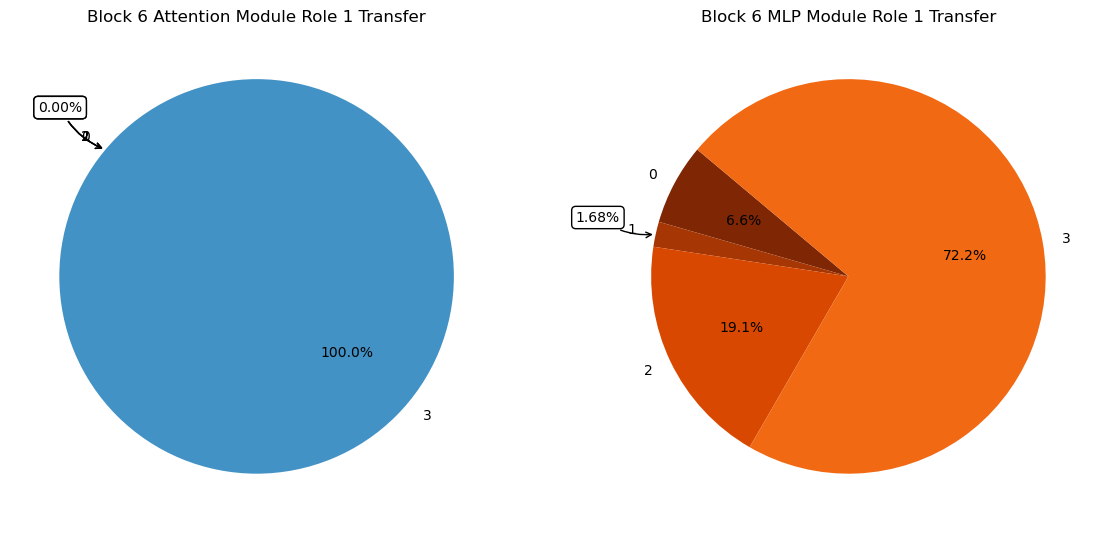

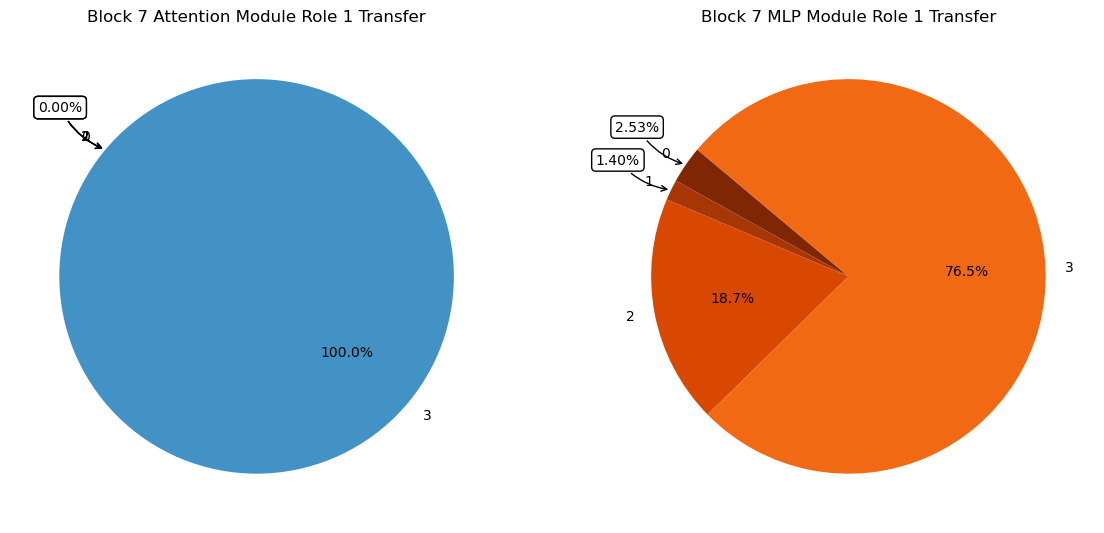

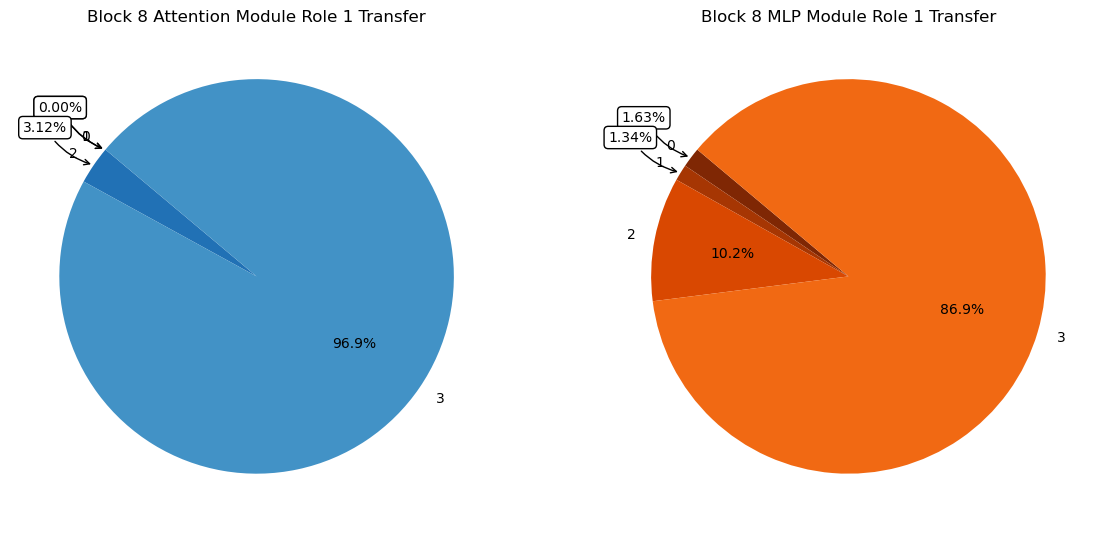

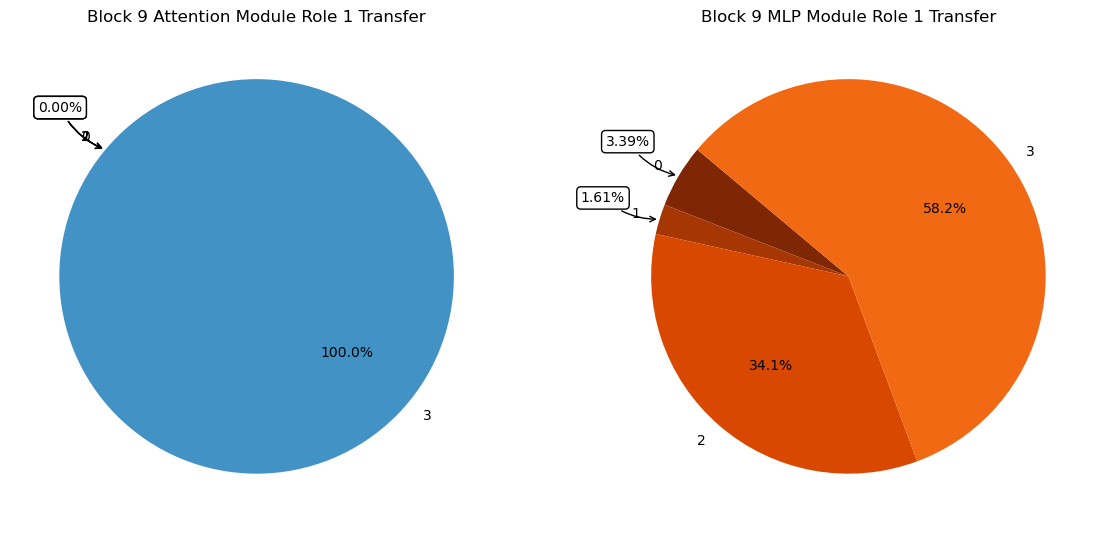

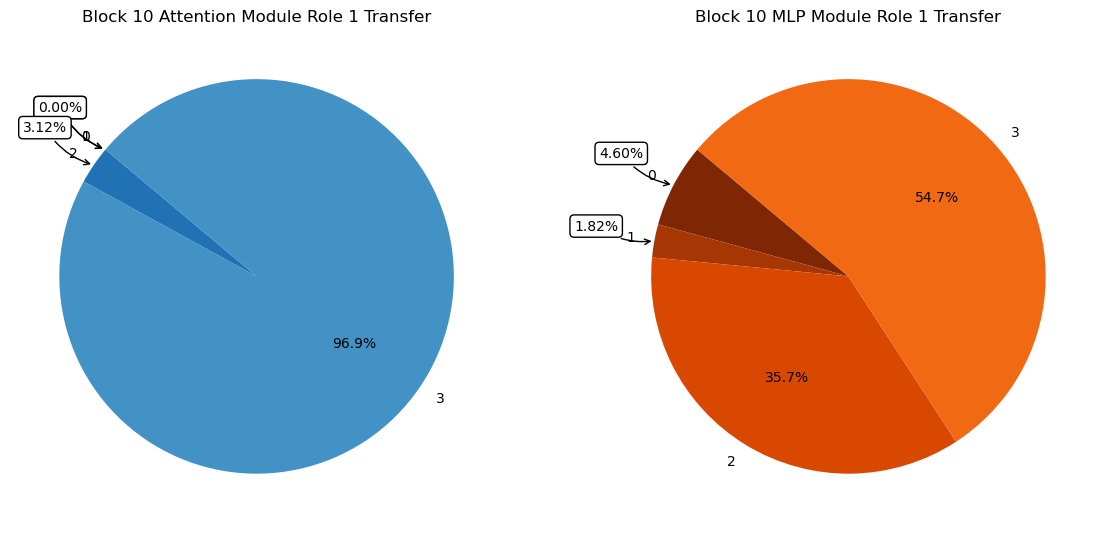

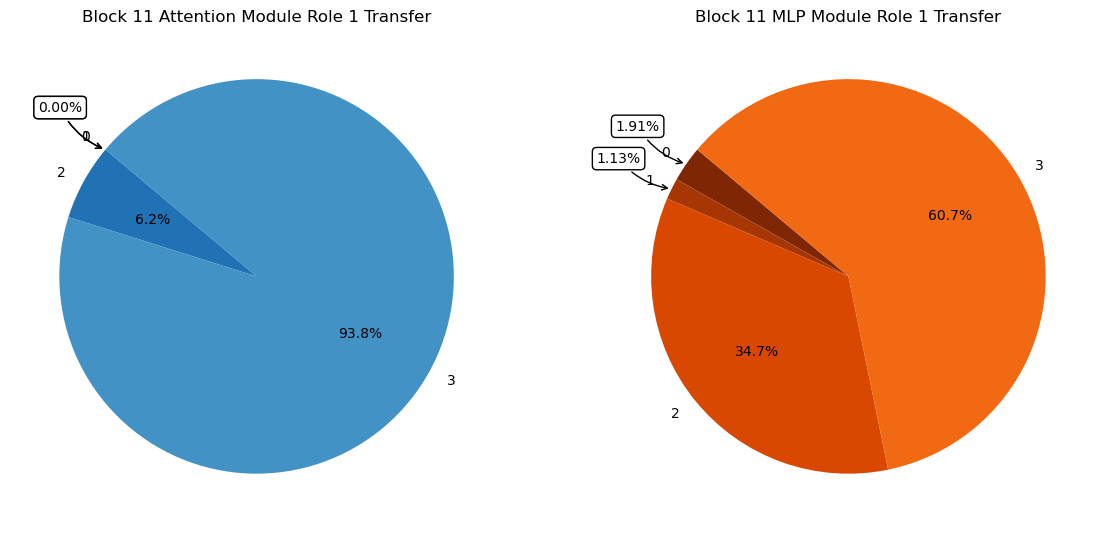

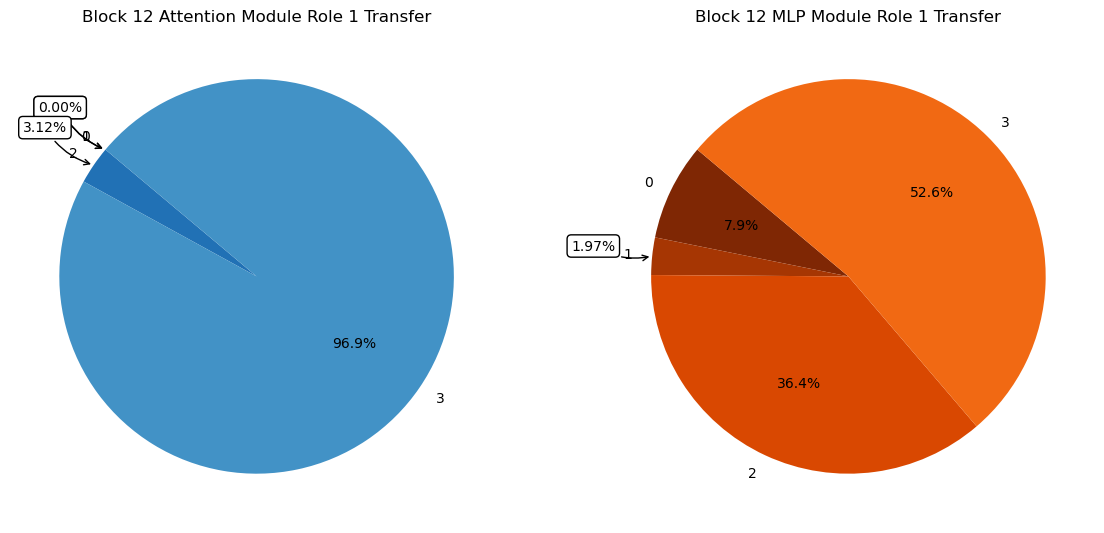

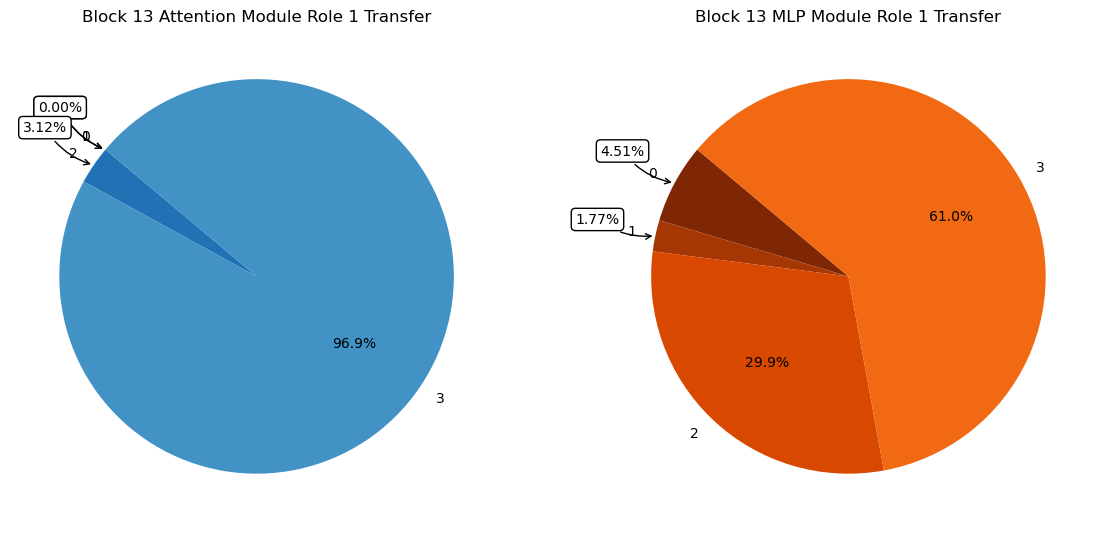

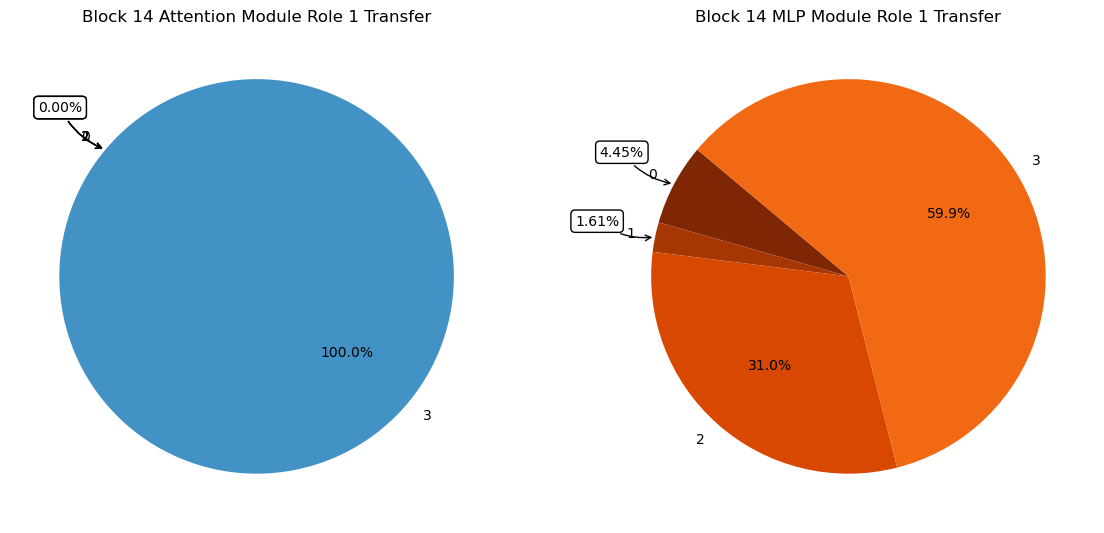

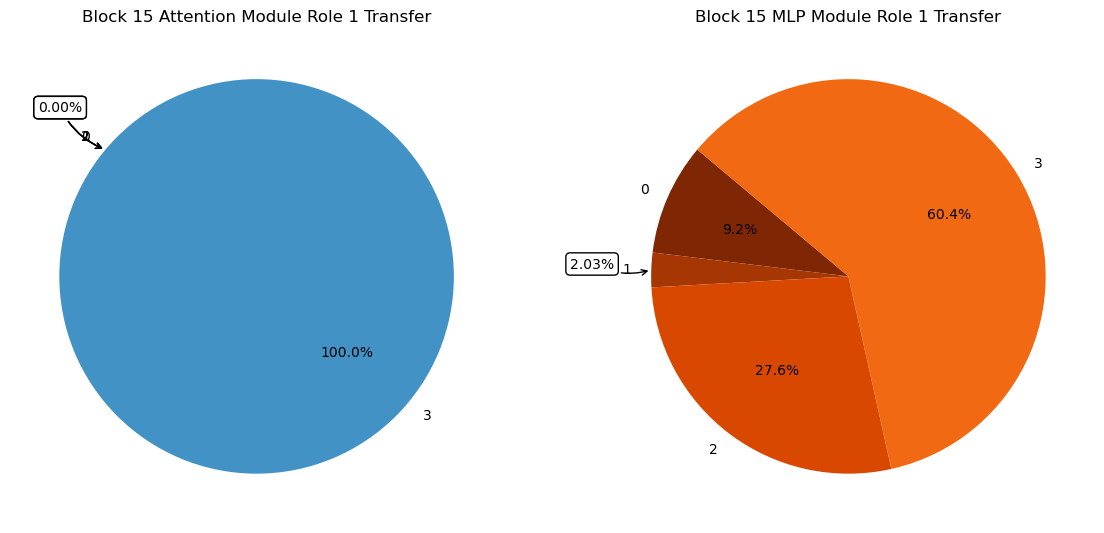

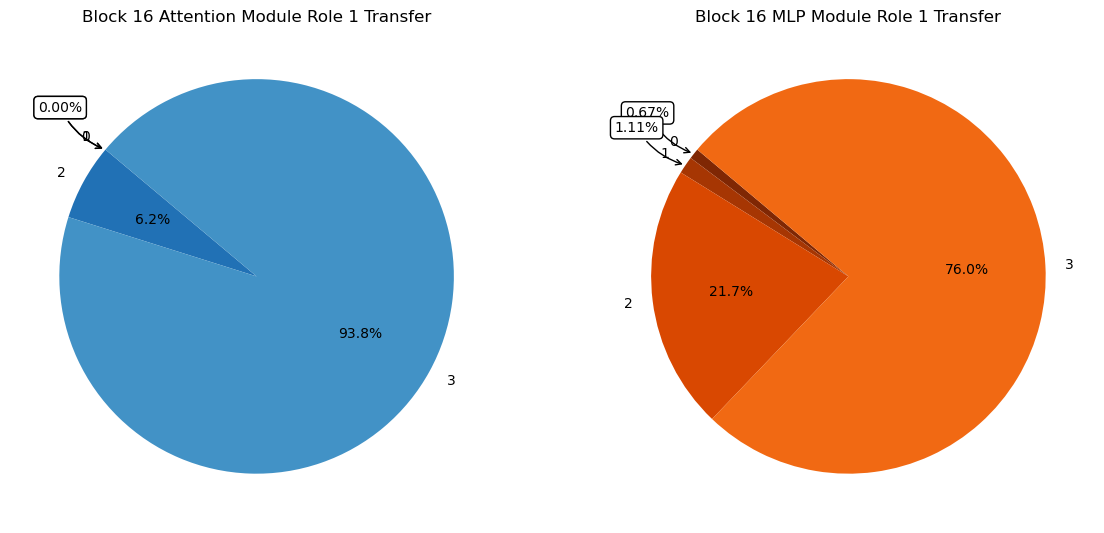

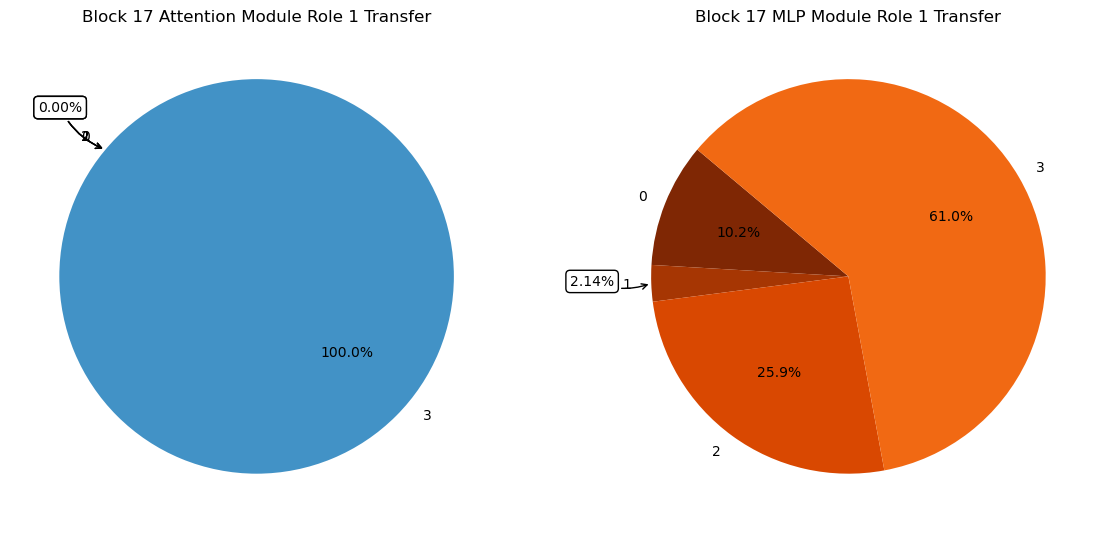

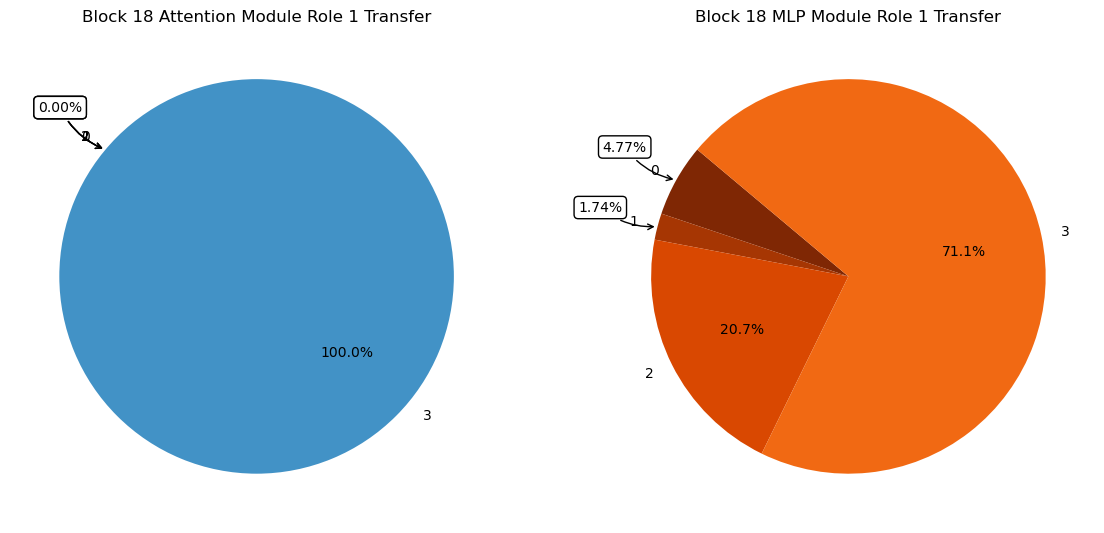

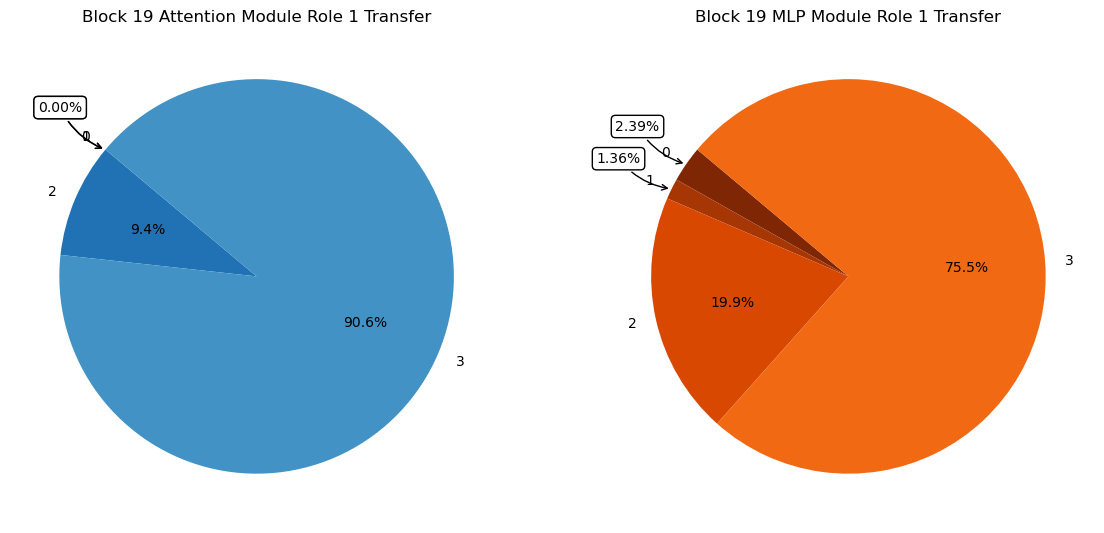

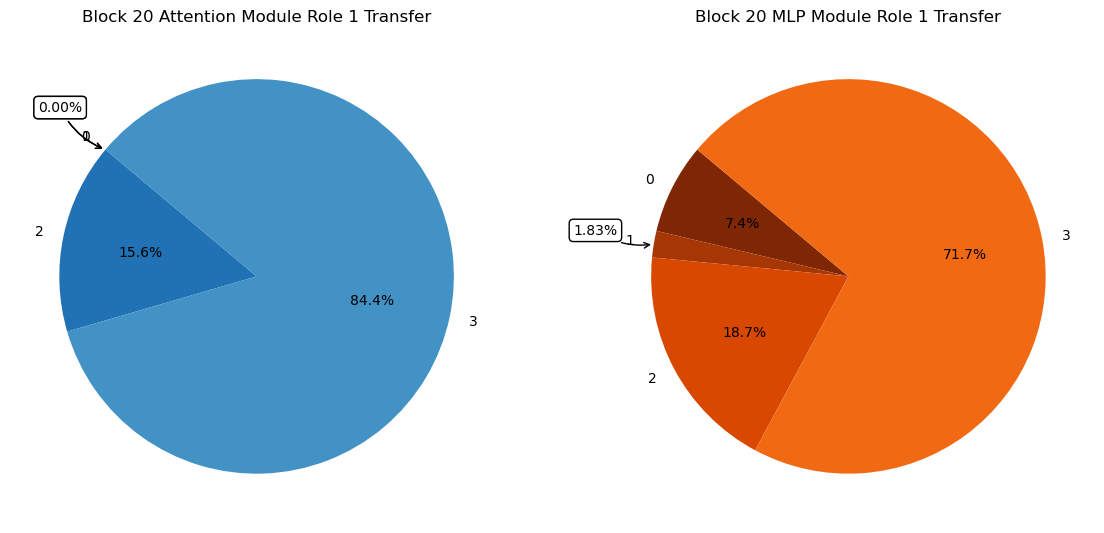

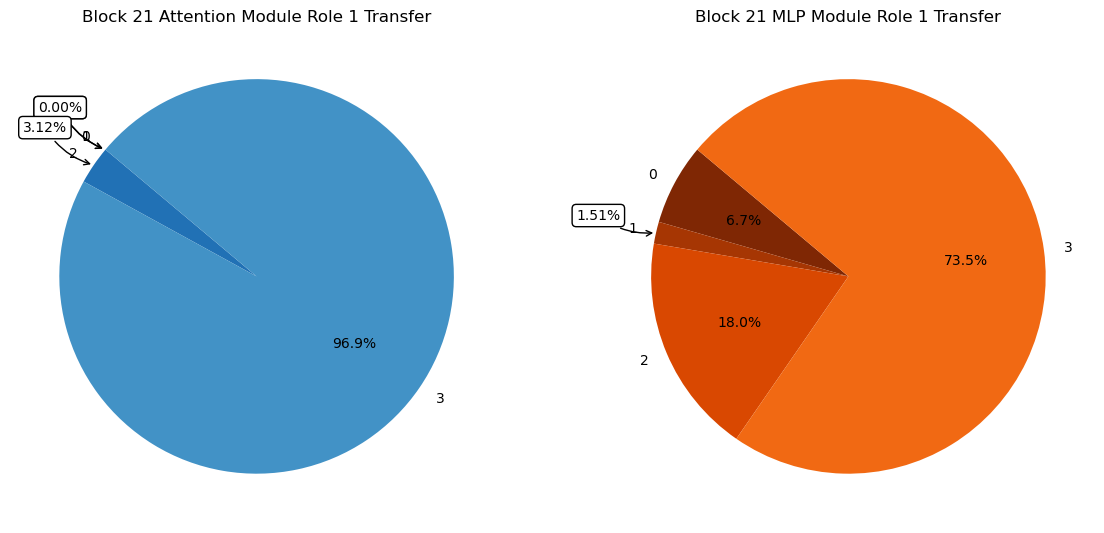

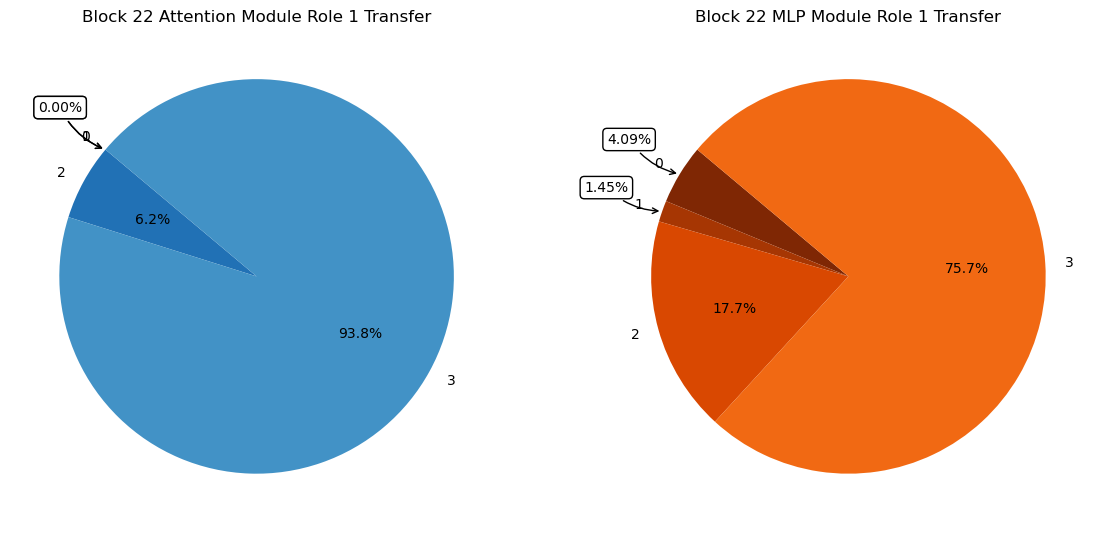

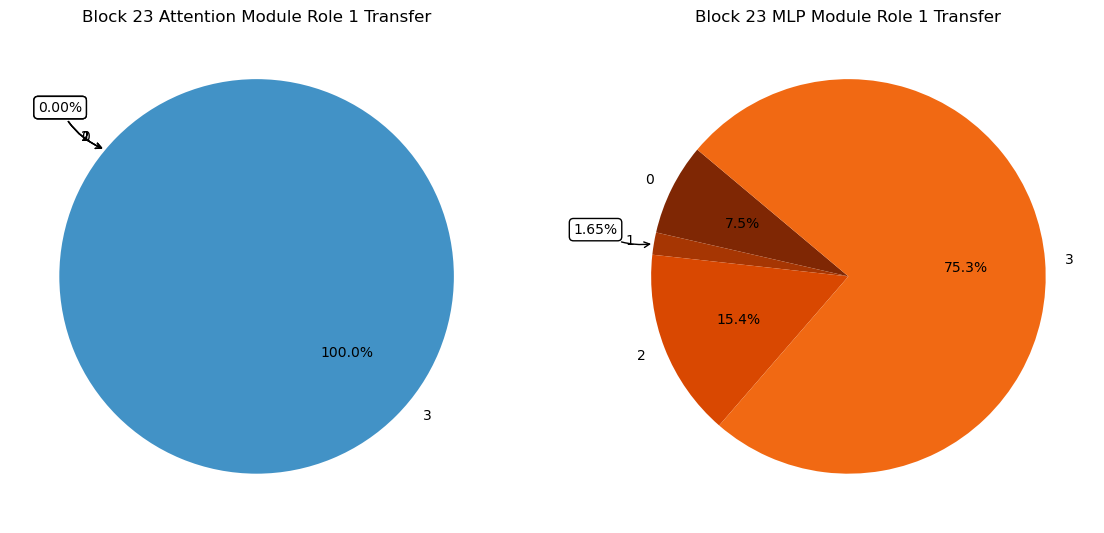

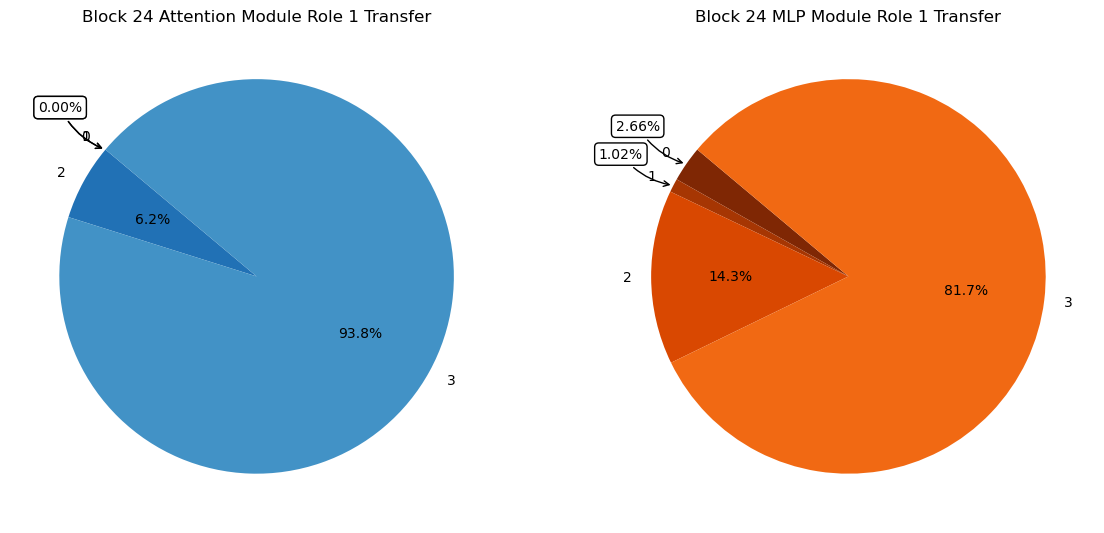

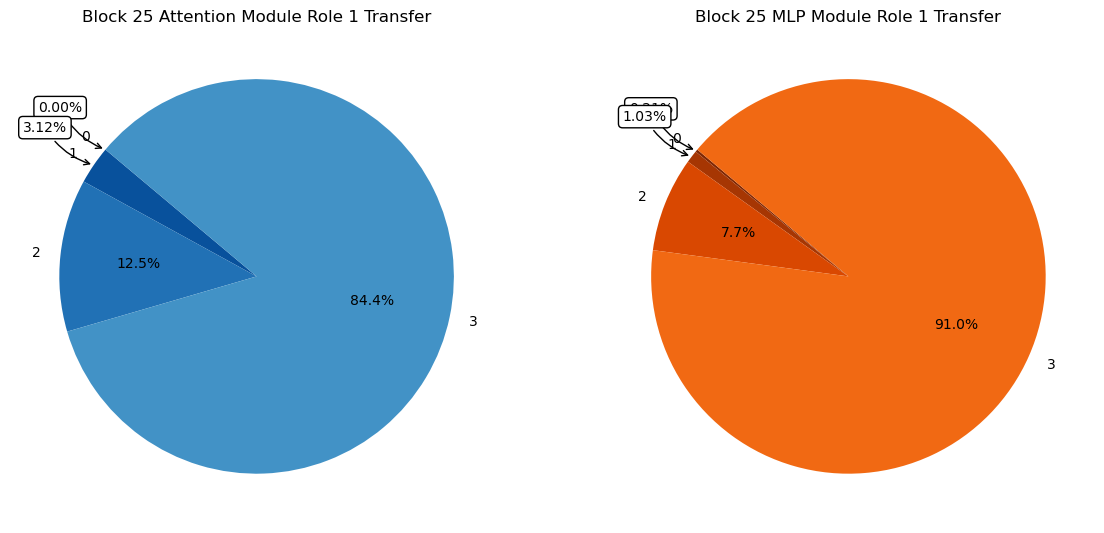

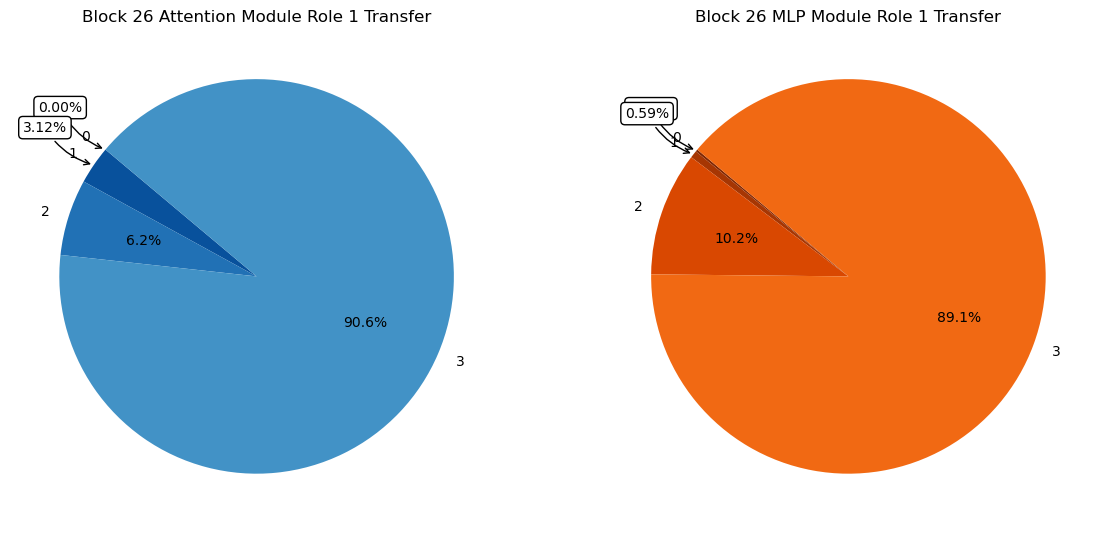

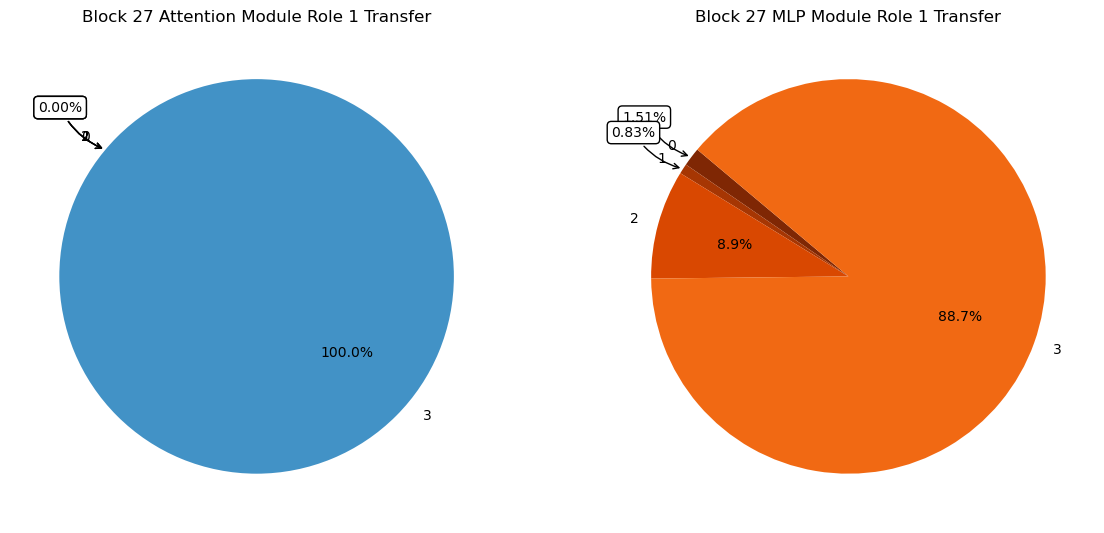

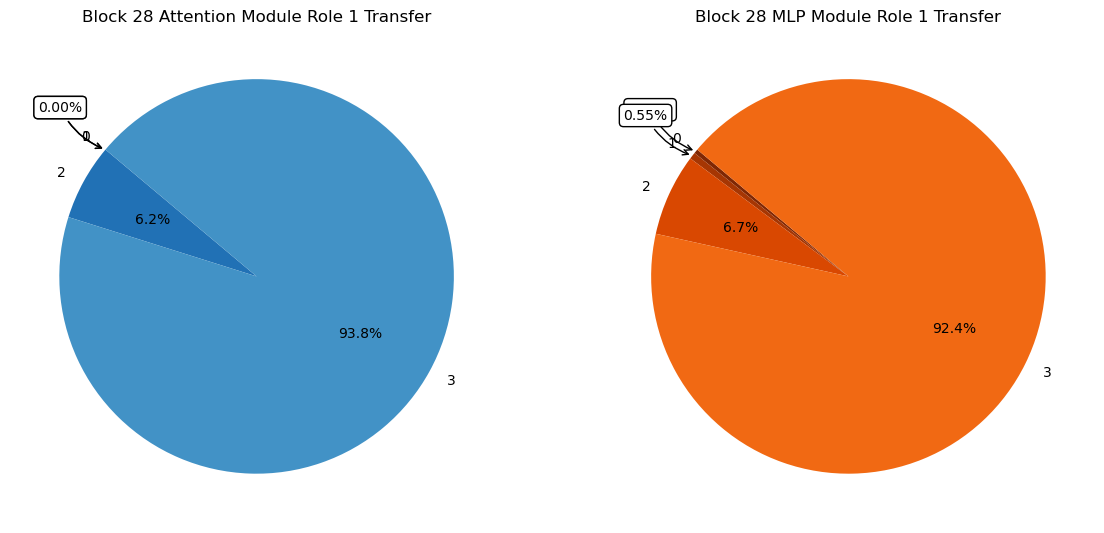

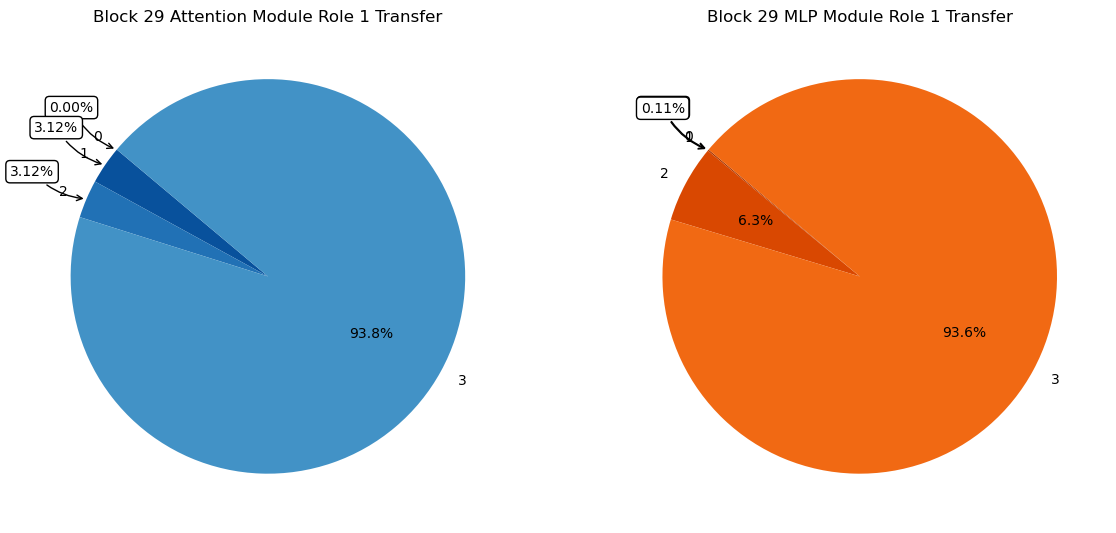

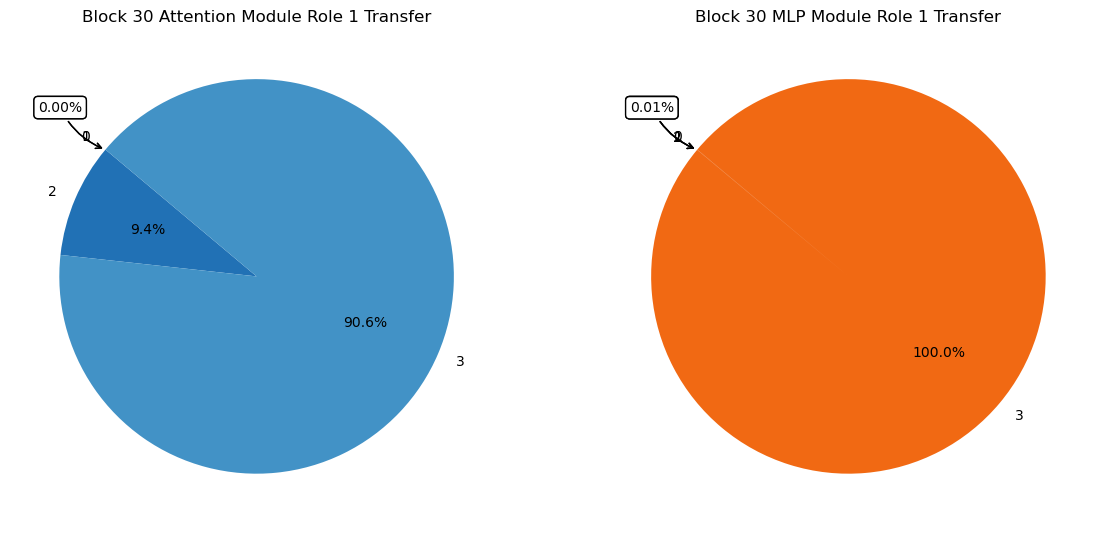

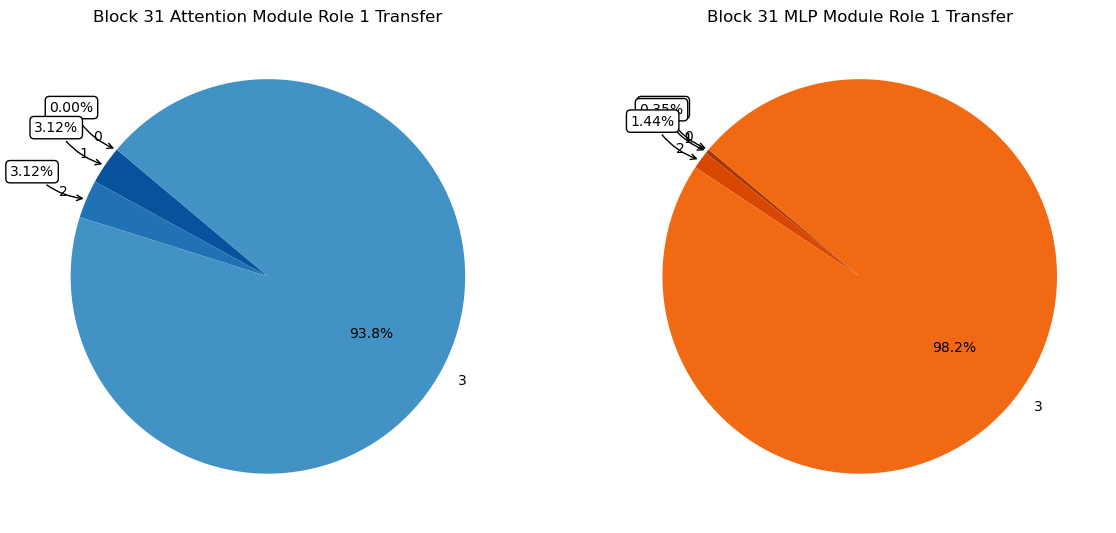

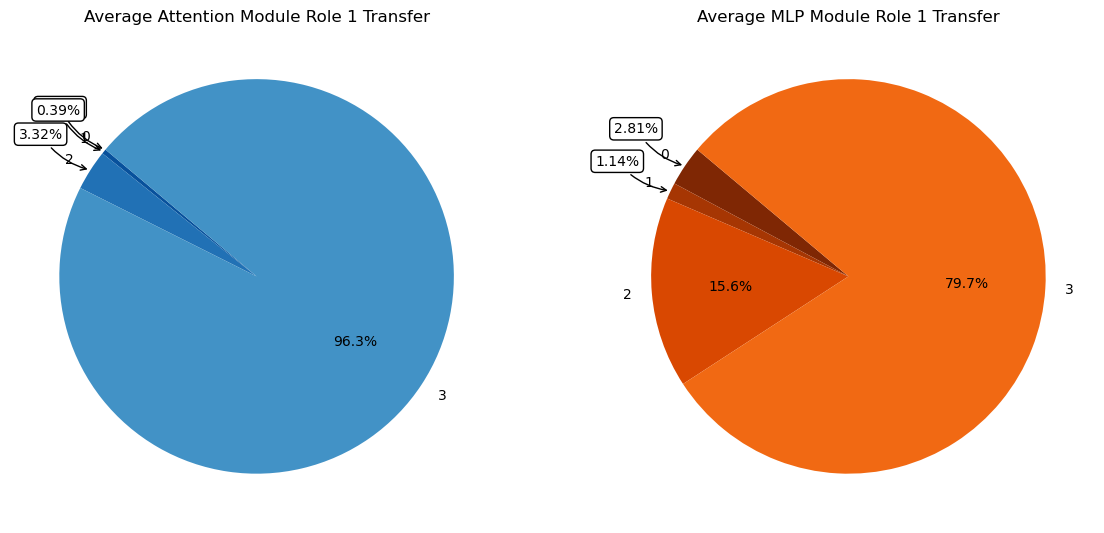

In [13]:
plot_role_transfer_pie_charts(block_transfer_att, block_transfer_mlp, role=1)
